In [39]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt 

import helper
import missingno as msno

import datetime

In [2]:
## Check date ranges

def check_dates(frames, frame_names):
    """
    """
    for idx, frame in enumerate(frames):
        date_range = str(frame['Time'].dt.date.min()) + ' to ' +str(frame['Time'].dt.date.max())
        print(f'{frame_names[idx]}: {date_range}')

In [50]:
## Set target name
target_name = 'zori_ssa'

###  Load pre-compiled dataframe

In [3]:
frame = pd.read_csv('all_vars.csv', index_col=0, parse_dates=['Time'])

In [4]:
frame.head()
frame.drop(columns=['zip_code', 'Time'], axis=1)

,zori_ssa,mintempC,maxtempC,precipMM,env_violation_count,num_daycare_permit,daycare_childcare_subsidies_ratio,daycare_corrective_action_ratio,daycare_adverse_action_ratio,Consumer Confidence Index TX,...,owner_occupied_housing_units,aggregate_travel_time_to_work,commuters_by_public_transportation,high_school_diploma,bachelors_degree,employed_pop,unemployed_pop,pop_in_labor_force,armed_forces,year
0,1390.0,5.870968,15.064516,1.009677,11.0,2.0,1.0,0.0,0.0,104.509,...,21257.0,1156010.0,714.0,3610.0,19996.0,35822.0,1250.0,37072.0,0.0,2014.0
1,1387.0,8.214286,16.571429,4.239286,1.0,0.0,0.0,0.0,0.0,111.777,...,21257.0,1156010.0,714.0,3610.0,19996.0,35822.0,1250.0,37072.0,0.0,2014.0
2,1384.0,10.709677,19.580645,2.912903,0.0,0.0,0.0,0.0,0.0,108.685,...,21257.0,1156010.0,714.0,3610.0,19996.0,35822.0,1250.0,37072.0,0.0,2014.0
3,1381.0,15.133333,24.933333,2.193333,4.0,0.0,0.0,0.0,0.0,120.100,...,21257.0,1156010.0,714.0,3610.0,19996.0,35822.0,1250.0,37072.0,0.0,2014.0
4,1379.0,18.548387,28.419355,5.674194,0.0,0.0,0.0,0.0,0.0,131.200,...,21257.0,1156010.0,714.0,3610.0,19996.0,35822.0,1250.0,37072.0,0.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19775,1545.0,13.225806,22.580645,0.787097,0.0,0.0,0.0,0.0,0.0,125.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19776,1555.0,15.400000,26.066667,3.783333,0.0,0.0,0.0,0.0,0.0,127.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19777,1565.0,19.806452,28.161290,9.587097,0.0,0.0,0.0,0.0,0.0,131.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19778,1575.0,23.133333,32.433333,4.290000,0.0,0.0,0.0,0.0,0.0,133.100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
frame.isnull().sum()

Time                  0
zip_code              0
zori_ssa              0
mintempC              0
maxtempC              0
                     ..
employed_pop          0
unemployed_pop        0
pop_in_labor_force    0
armed_forces          0
year                  0
Length: 117, dtype: int64

In [6]:
## These are the non-numerical columns
obj_items = frame.select_dtypes(include=['object'])
# obj_items are 'State', 'metro', 'county', 'city'

## For now, drop them
frame = frame.drop(columns=['State', 'metro', 'county', 'city'], axis=1)

In [7]:
y = frame['zori_ssa']
X = frame.drop(columns=['zori_ssa', 'Time', 'zip_code'], axis=1)

In [8]:
for col in frame.columns:
    print(col)

Time
zip_code
zori_ssa
mintempC
maxtempC
precipMM
env_violation_count
num_daycare_permit
daycare_childcare_subsidies_ratio
daycare_corrective_action_ratio
daycare_adverse_action_ratio
Consumer Confidence Index TX
Consumer Confidence West South Central
Consumer Confidence Index US
Consumer Price Index TX
Consumer Price Index U.S.
Nonfarm Employment TX
Nonfarm Employment U.S.
Unemployment TX
Unemployment U.S.
Single Family Building Permits TX
Multi Family Building Permits TX
Existing Single Family Home Sales TX
Existing Single Family Home Price TX
Non Residential Building Construction
Total Sales Tax Collections Retail TX
Total Sales Tax Collections TX
Retail Gasoline Price TX
Retail Diesel Price TX
Nonfarm Employment Illinois
Nonfarm Employment Florida
Nonfarm Employment New York
Nonfarm Employment Texas
Nonfarm Employment California
Gross Value Crude Oil Production
Gross Value Natural Gas Production
Motor Fuel Taxed Gasoline
Motor Fuel Taxed Diesel
ur
delta_ur
monthly_avg_gas_price
del

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)






In [10]:
X_train.columns

Index(['mintempC', 'maxtempC', 'precipMM', 'env_violation_count',
       'num_daycare_permit', 'daycare_childcare_subsidies_ratio',
       'daycare_corrective_action_ratio', 'daycare_adverse_action_ratio',
       'Consumer Confidence Index TX',
       'Consumer Confidence West South Central',
       ...
       'owner_occupied_housing_units', 'aggregate_travel_time_to_work',
       'commuters_by_public_transportation', 'high_school_diploma',
       'bachelors_degree', 'employed_pop', 'unemployed_pop',
       'pop_in_labor_force', 'armed_forces', 'year'],
      dtype='object', length=110)

In [11]:
for i in X_train.columns:
    print(i)

mintempC
maxtempC
precipMM
env_violation_count
num_daycare_permit
daycare_childcare_subsidies_ratio
daycare_corrective_action_ratio
daycare_adverse_action_ratio
Consumer Confidence Index TX
Consumer Confidence West South Central
Consumer Confidence Index US
Consumer Price Index TX
Consumer Price Index U.S.
Nonfarm Employment TX
Nonfarm Employment U.S.
Unemployment TX
Unemployment U.S.
Single Family Building Permits TX
Multi Family Building Permits TX
Existing Single Family Home Sales TX
Existing Single Family Home Price TX
Non Residential Building Construction
Total Sales Tax Collections Retail TX
Total Sales Tax Collections TX
Retail Gasoline Price TX
Retail Diesel Price TX
Nonfarm Employment Illinois
Nonfarm Employment Florida
Nonfarm Employment New York
Nonfarm Employment Texas
Nonfarm Employment California
Gross Value Crude Oil Production
Gross Value Natural Gas Production
Motor Fuel Taxed Gasoline
Motor Fuel Taxed Diesel
ur
delta_ur
monthly_avg_gas_price
delta_monthly_avg_gas_pric

### Load New Dataset

In [12]:
## load target
main_frame = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col=0, parse_dates=['Time'])

## ACS
acs = pd.read_csv('cleaned_data/acs_master11to18_clean.csv', index_col=0, parse_dates=['Time'])
acs2 = pd.read_csv('cleaned_data/acs2_clean.csv', index_col=0, parse_dates=['Time'])

In [13]:
## Get list of feature files
feature_frames = [main_frame,
#                     weather, 
#                    env_viol, 
#                    daycare, 
#                    econ, 
#                    city_unemp, 
#                    gas_prices, 
#                    monthly_tnx, 
#                    polling, 
#                    covid, 
#                    new_biz_out, 
#                    new_biz_tax, 
#                    sales_tax, 
#                    sap,
                   acs,
                   acs2]
feature_frame_names = ['main_frame',
#                     'weather', 
#                    'env_viol', 
#                    'daycare', 
#                    'econ', 
#                    'city_unemp', 
#                    'gas_prices', 
#                    'monthly_tnx', 
#                    'polling', 
#                    'covid', 
#                    'new_biz_out', 
#                    'new_biz_tax', 
#                    'sales_tax', 
#                    'sap',
                   'acs',
                   'acs2']

In [14]:
## Check if any columns in common
acs2_set = set(acs2.columns.to_list())
acs_set = set(acs.columns.to_list())
print(f'in ACS2 but not ACS')
print(f'{acs2_set - acs_set}\n')
print(f'in ACS but not ACS2\n')
print(f'{acs_set - acs2_set}\n')
print(f'in both\n')
print(f'{acs2_set.intersection(acs_set)}')

in ACS2 but not ACS
{'bicycle_population', 'men_with_professional_degree', 'housing_units_10_to_19_units_owned', 'housing_units_3_to_4_units_rented', 'housing_units_mobile_home_owned', 'single_men', 'walking_to_work_population', 'housing_units_20_to_49_units_rented', 'housing_units_other_type', 'housing_units_10_to_19_units', 'average_household_size_owners', 'male_45_to_49', 'female_22_to_24', 'driving_alone_population', 'married_women_spouse_present', 'median_rooms', 'total_population_in_renter_occupied_units', 'housing_units_10_to_19_units_rented', 'housing_units_mobile_home', 'quintile_2_mean_income', 'top_5_percent_mean_income', 'housing_units_duplex_owned', 'housing_units_20_to_49_units', 'female_75_to_79', 'female_70_to_74', 'commuting_population', 'quintile_1_income_share', 'male_67_to_69', 'housing_units_5_to_9_units_rented', 'housing_units_over_50_units', 'women_with_doctoral_degree', 'male_35_to_39', 'housing_units_5_to_9_units', 'housing_units_20_to_49_units_owned', 'women_w

In [15]:
## Check date ranges

check_dates(feature_frames, feature_frame_names)


main_frame: 2014-01-01 to 2021-07-01
acs: 2011-01-01 to 2018-12-01
acs2: 2011-01-01 to 2019-12-01


In [16]:
## Create lags based on time differences

### Tried with lags didn't work

In [20]:
# ## Merge all the data
# shifts = {12:[acs2], 24:[acs]}
# acs_cols = acs.columns.to_list()
# merged_frame = helper.time_lag_merge(main_frame, acs, {24:acs_cols})
# # merged_frame = helper.time_lag_merge(merged_frame, acs2, {12:'acs2'})
# check_dates([merged_frame], ['merged_frame'])

In [34]:
merged_frame['Time'].dtype

dtype('<M8[ns]')

In [35]:
type(latest_date)

pandas._libs.tslibs.timestamps.Timestamp

In [44]:
merged_frame = helper.time_lag_merge(main_frame, acs)
merged_frame = helper.time_lag_merge(main_frame, acs2)

# earliest_date = merged_frame['Time'].dt.time.min()
# train_test_date = pd.to_datetime('1122017', format = '%d%m%Y')
# latest_date = pd.to_datetime('1122018', format = '%d%m%Y')

earliest_date = datetime.datetime(2014,1,1)
train_test_date = datetime.datetime(2017,12,1)
latest_date = datetime.datetime(2018,12,1)

## Cut off dates before earliest date and after lastest one
print(f'original shape: {merged_frame.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] > earliest_date]

print(f'after first cut: {merged_frame_cut.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] < latest_date]

print(f'final: {merged_frame_cut.shape}')

original shape: (19565, 157)
after first cut: (19350, 157)
final: (12685, 157)


<AxesSubplot:>

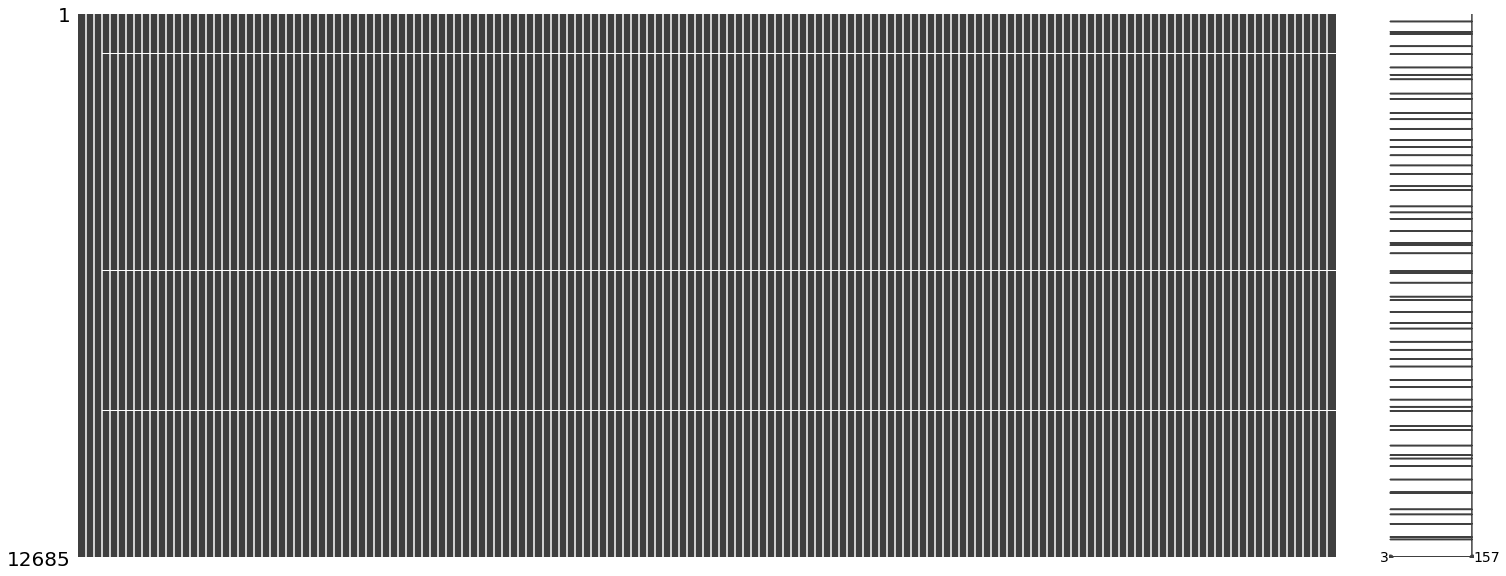

In [45]:
## Check MSNO
merged_frame_cut = merged_frame_cut.sort_values(by='Time')
msno.matrix(merged_frame_cut)

In [49]:
## Drop na values
merged_frame_cut = merged_frame_cut.dropna()
merged_frame_cut = merged_frame_cut.reset_index(drop=True)
print(f'shape: {merged_frame_cut.shape}')

shape: (12626, 157)


In [47]:
merged_frame_cut.head()

,Time,zip_code,zori_ssa,commuting_population,divorced_men,driving_alone_population,housing_units_built_1940_to_1949,quintile_2_income_share,housing_units_10_to_19_units_rented,quintile_3_income_share,...,housing_units_over_50_units,women_with_bachelors_degree,male_45_to_49,housing_units_built_1960_to_1969,housing_units_duplex_owned,married_women_spouse_present,men_with_hs_diploma,quintile_5_mean_income,quintile_2_mean_income,male_75_to_79
0,2014-01-01,77494,1390.0,35176.0,959.0,27840.0,115.0,12.28,620.0,17.76,...,506.0,9997.0,3109.0,0.0,0.0,19112.0,1407.0,303338.0,91207.0,250.0
7553,2014-01-01,75063,1361.0,20363.0,1228.0,16577.0,150.0,9.54,2856.0,15.03,...,1285.0,5472.0,1667.0,95.0,19.0,7231.0,1159.0,249005.0,48620.0,203.0
4186,2014-01-01,75211,800.0,31701.0,1973.0,23754.0,5231.0,10.53,1963.0,16.26,...,1216.0,1096.0,2620.0,3288.0,13.0,10388.0,5799.0,101203.0,23938.0,303.0
15379,2014-01-01,78239,951.0,12101.0,983.0,9901.0,79.0,10.33,26.0,17.05,...,98.0,1244.0,815.0,1112.0,0.0,5359.0,2733.0,145648.0,34362.0,458.0
14651,2014-01-01,78746,1369.0,13403.0,653.0,10527.0,53.0,7.51,654.0,12.93,...,832.0,4397.0,1134.0,751.0,25.0,6790.0,424.0,548756.0,74764.0,261.0


In [53]:
## Check for categoricals
merged_frame_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12626 entries, 0 to 12625
Columns: 157 entries, Time to male_75_to_79
dtypes: datetime64[ns](1), float64(155), int64(1)
memory usage: 15.1 MB


In [57]:
## Train will be before 12/1/2017, test is from 12/1/2017 to 12/1/2017
merged_train = merged_frame_cut[merged_frame_cut['Time'] < train_test_date]
merged_test  = merged_frame_cut[merged_frame_cut['Time'] > train_test_date]

In [58]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


0:	learn: 1245.8411308	test: 1241.8597065	best: 1241.8597065 (0)	total: 60.6ms	remaining: 6s
1:	learn: 1209.4810984	test: 1205.5431800	best: 1205.5431800 (1)	total: 65.2ms	remaining: 3.19s
2:	learn: 1174.2587155	test: 1170.3803968	best: 1170.3803968 (2)	total: 69.9ms	remaining: 2.26s
3:	learn: 1140.0646251	test: 1136.3367062	best: 1136.3367062 (3)	total: 73.8ms	remaining: 1.77s
4:	learn: 1107.0486776	test: 1103.4003589	best: 1103.4003589 (4)	total: 76.9ms	remaining: 1.46s
5:	learn: 1074.9409434	test: 1071.3293339	best: 1071.3293339 (5)	total: 79.9ms	remaining: 1.25s
6:	learn: 1044.0231426	test: 1040.4584475	best: 1040.4584475 (6)	total: 83.6ms	remaining: 1.11s
7:	learn: 1014.1550775	test: 1010.6056219	best: 1010.6056219 (7)	total: 86.5ms	remaining: 995ms
8:	learn: 985.1468465	test: 981.7065815	best: 981.7065815 (8)	total: 89.3ms	remaining: 903ms
9:	learn: 956.8606118	test: 953.3734665	best: 953.3734665 (9)	total: 91.5ms	remaining: 824ms
10:	learn: 929.7007243	test: 926.2581625	best: 92

42:	learn: 73.2053871	test: 76.6106148	best: 76.6106148 (42)	total: 110ms	remaining: 146ms
43:	learn: 71.8606377	test: 74.6386161	best: 74.6386161 (43)	total: 114ms	remaining: 145ms
44:	learn: 71.0106620	test: 74.2344215	best: 74.2344215 (44)	total: 119ms	remaining: 146ms
45:	learn: 70.2557472	test: 73.5048218	best: 73.5048218 (45)	total: 123ms	remaining: 144ms
46:	learn: 69.3595008	test: 72.2107732	best: 72.2107732 (46)	total: 126ms	remaining: 142ms
47:	learn: 68.4536851	test: 71.1534050	best: 71.1534050 (47)	total: 129ms	remaining: 140ms
48:	learn: 67.3032467	test: 70.4538959	best: 70.4538959 (48)	total: 132ms	remaining: 138ms
49:	learn: 66.5181000	test: 69.8474369	best: 69.8474369 (49)	total: 136ms	remaining: 136ms
50:	learn: 65.7495001	test: 68.8544369	best: 68.8544369 (50)	total: 140ms	remaining: 134ms
51:	learn: 64.8776001	test: 67.6513903	best: 67.6513903 (51)	total: 144ms	remaining: 133ms
52:	learn: 64.0131604	test: 66.5208542	best: 66.5208542 (52)	total: 149ms	remaining: 132ms

74:	learn: 215.8335994	test: 216.9829431	best: 216.9829431 (74)	total: 195ms	remaining: 64.9ms
75:	learn: 213.1417547	test: 214.3558267	best: 214.3558267 (75)	total: 198ms	remaining: 62.6ms
76:	learn: 210.5738210	test: 211.7877699	best: 211.7877699 (76)	total: 201ms	remaining: 60.1ms
77:	learn: 208.0294687	test: 209.2249510	best: 209.2249510 (77)	total: 204ms	remaining: 57.6ms
78:	learn: 205.5207759	test: 206.7010618	best: 206.7010618 (78)	total: 207ms	remaining: 55.1ms
79:	learn: 203.2935833	test: 204.5915715	best: 204.5915715 (79)	total: 210ms	remaining: 52.6ms
80:	learn: 201.1386938	test: 202.4889370	best: 202.4889370 (80)	total: 213ms	remaining: 50.1ms
81:	learn: 198.9115365	test: 200.2469375	best: 200.2469375 (81)	total: 216ms	remaining: 47.5ms
82:	learn: 196.9162043	test: 198.3113170	best: 198.3113170 (82)	total: 219ms	remaining: 44.9ms
83:	learn: 195.0117578	test: 196.5705113	best: 196.5705113 (83)	total: 223ms	remaining: 42.4ms
84:	learn: 193.0214837	test: 194.6569098	best: 194

13:	learn: 853.1200891	test: 849.6679959	best: 849.6679959 (13)	total: 34.4ms	remaining: 211ms
14:	learn: 829.0313930	test: 825.5468687	best: 825.5468687 (14)	total: 37.9ms	remaining: 215ms
15:	learn: 805.7948193	test: 802.2657038	best: 802.2657038 (15)	total: 41.3ms	remaining: 217ms
16:	learn: 783.3919219	test: 779.8255430	best: 779.8255430 (16)	total: 44.4ms	remaining: 217ms
17:	learn: 761.3114624	test: 757.8331184	best: 757.8331184 (17)	total: 47.7ms	remaining: 217ms
18:	learn: 740.2827936	test: 736.8390584	best: 736.8390584 (18)	total: 50.9ms	remaining: 217ms
19:	learn: 719.6680811	test: 716.3017068	best: 716.3017068 (19)	total: 54ms	remaining: 216ms
20:	learn: 699.8380238	test: 696.5702817	best: 696.5702817 (20)	total: 57.1ms	remaining: 215ms
21:	learn: 680.7372846	test: 677.5483302	best: 677.5483302 (21)	total: 60.1ms	remaining: 213ms
22:	learn: 662.0533245	test: 658.9452381	best: 658.9452381 (22)	total: 63.4ms	remaining: 212ms
23:	learn: 644.0348592	test: 640.9477986	best: 640.9

21:	learn: 101.2010328	test: 102.8579446	best: 102.8579446 (21)	total: 51.6ms	remaining: 183ms
22:	learn: 99.4084705	test: 100.6241304	best: 100.6241304 (22)	total: 54.7ms	remaining: 183ms
23:	learn: 97.9806210	test: 99.7881847	best: 99.7881847 (23)	total: 58.2ms	remaining: 184ms
24:	learn: 96.2327341	test: 98.5534801	best: 98.5534801 (24)	total: 61.7ms	remaining: 185ms
25:	learn: 94.3832522	test: 96.5333220	best: 96.5333220 (25)	total: 64.8ms	remaining: 185ms
26:	learn: 92.3759747	test: 95.4205981	best: 95.4205981 (26)	total: 68.7ms	remaining: 186ms
27:	learn: 90.0769135	test: 92.6588571	best: 92.6588571 (27)	total: 71.7ms	remaining: 184ms
28:	learn: 88.2998401	test: 90.7898705	best: 90.7898705 (28)	total: 75.6ms	remaining: 185ms
29:	learn: 87.0643717	test: 89.5041732	best: 89.5041732 (29)	total: 79.1ms	remaining: 185ms
30:	learn: 85.7423618	test: 87.9140904	best: 87.9140904 (30)	total: 83.7ms	remaining: 186ms
31:	learn: 84.6241192	test: 86.6853814	best: 86.6853814 (31)	total: 86.2ms	

65:	learn: 246.6129652	test: 247.1545828	best: 247.1545828 (65)	total: 153ms	remaining: 78.8ms
66:	learn: 242.7294547	test: 243.3467027	best: 243.3467027 (66)	total: 156ms	remaining: 76.7ms
67:	learn: 238.7961251	test: 239.4005791	best: 239.4005791 (67)	total: 159ms	remaining: 75ms
68:	learn: 235.1577614	test: 235.8632158	best: 235.8632158 (68)	total: 163ms	remaining: 73.1ms
69:	learn: 231.5941607	test: 232.3770910	best: 232.3770910 (69)	total: 166ms	remaining: 71.1ms
70:	learn: 228.2524678	test: 229.0277342	best: 229.0277342 (70)	total: 169ms	remaining: 68.9ms
71:	learn: 225.0944113	test: 225.9799214	best: 225.9799214 (71)	total: 172ms	remaining: 66.8ms
72:	learn: 221.8808942	test: 222.8818258	best: 222.8818258 (72)	total: 175ms	remaining: 64.9ms
73:	learn: 218.9063839	test: 220.0865107	best: 220.0865107 (73)	total: 178ms	remaining: 62.7ms
74:	learn: 216.0157842	test: 217.3256646	best: 217.3256646 (74)	total: 181ms	remaining: 60.5ms
75:	learn: 213.3201989	test: 214.6902342	best: 214.6

16:	learn: 783.2233253	test: 779.6679972	best: 779.6679972 (16)	total: 39.1ms	remaining: 306ms
17:	learn: 761.1377365	test: 757.6711294	best: 757.6711294 (17)	total: 42.3ms	remaining: 310ms
18:	learn: 740.1045728	test: 736.6726450	best: 736.6726450 (18)	total: 45.5ms	remaining: 314ms
19:	learn: 719.4870585	test: 716.1324019	best: 716.1324019 (19)	total: 48.7ms	remaining: 317ms
20:	learn: 699.6530477	test: 696.3975138	best: 696.3975138 (20)	total: 51.9ms	remaining: 319ms
21:	learn: 680.5465653	test: 677.3707766	best: 677.3707766 (21)	total: 55.3ms	remaining: 322ms
22:	learn: 661.8601643	test: 658.7652233	best: 658.7652233 (22)	total: 58.3ms	remaining: 322ms
23:	learn: 643.8416825	test: 640.7677960	best: 640.7677960 (23)	total: 61.6ms	remaining: 324ms
24:	learn: 626.4214016	test: 623.4404096	best: 623.4404096 (24)	total: 64.9ms	remaining: 324ms
25:	learn: 609.7001359	test: 606.7950061	best: 606.7950061 (25)	total: 67.8ms	remaining: 323ms
26:	learn: 593.3627360	test: 590.5683296	best: 590

8:	learn: 139.6342128	test: 140.9461770	best: 140.9461770 (8)	total: 26.7ms	remaining: 419ms
9:	learn: 135.0651913	test: 136.5971424	best: 136.5971424 (9)	total: 30.4ms	remaining: 426ms
10:	learn: 131.9978080	test: 134.4541313	best: 134.4541313 (10)	total: 33.6ms	remaining: 425ms
11:	learn: 127.7687246	test: 131.0817150	best: 131.0817150 (11)	total: 36.6ms	remaining: 421ms
12:	learn: 124.3301835	test: 127.6687106	best: 127.6687106 (12)	total: 40ms	remaining: 421ms
13:	learn: 120.7504439	test: 124.5655900	best: 124.5655900 (13)	total: 43.1ms	remaining: 418ms
14:	learn: 117.5662648	test: 120.4901769	best: 120.4901769 (14)	total: 46.9ms	remaining: 422ms
15:	learn: 114.4354884	test: 117.3649548	best: 117.3649548 (15)	total: 50.1ms	remaining: 420ms
16:	learn: 111.7960321	test: 114.6361238	best: 114.6361238 (16)	total: 53.9ms	remaining: 422ms
17:	learn: 109.1873562	test: 112.6188188	best: 112.6188188 (17)	total: 57.4ms	remaining: 421ms
18:	learn: 107.3390072	test: 110.3708897	best: 110.37088

143:	learn: 29.8512637	test: 32.6446695	best: 32.6446695 (143)	total: 413ms	remaining: 17.2ms
144:	learn: 29.6977735	test: 32.4126713	best: 32.4126713 (144)	total: 418ms	remaining: 14.4ms
145:	learn: 29.4816781	test: 32.3024162	best: 32.3024162 (145)	total: 422ms	remaining: 11.6ms
146:	learn: 29.3693559	test: 32.2869813	best: 32.2869813 (146)	total: 426ms	remaining: 8.7ms
147:	learn: 29.2643250	test: 32.1353570	best: 32.1353570 (147)	total: 431ms	remaining: 5.82ms
148:	learn: 29.1316690	test: 32.0791693	best: 32.0791693 (148)	total: 435ms	remaining: 2.92ms
149:	learn: 28.9612573	test: 31.9907056	best: 31.9907056 (149)	total: 439ms	remaining: 0us

bestTest = 31.9907056
bestIteration = 149

9:	loss: 31.9907056	best: 31.9907056 (9)	total: 3.41s	remaining: 29.3s
0:	learn: 1245.8478405	test: 1241.8656795	best: 1241.8656795 (0)	total: 5.43ms	remaining: 809ms
1:	learn: 1209.4936681	test: 1205.5547121	best: 1205.5547121 (1)	total: 10.1ms	remaining: 748ms
2:	learn: 1174.2759387	test: 1170.39660

87:	learn: 187.9832529	test: 189.7195053	best: 189.7195053 (87)	total: 361ms	remaining: 255ms
88:	learn: 186.3486358	test: 188.0835813	best: 188.0835813 (88)	total: 365ms	remaining: 250ms
89:	learn: 184.9479704	test: 186.7516398	best: 186.7516398 (89)	total: 368ms	remaining: 245ms
90:	learn: 183.5080497	test: 185.3952026	best: 185.3952026 (90)	total: 372ms	remaining: 241ms
91:	learn: 182.1085127	test: 184.0249174	best: 184.0249174 (91)	total: 376ms	remaining: 237ms
92:	learn: 180.8120407	test: 182.7040848	best: 182.7040848 (92)	total: 380ms	remaining: 233ms
93:	learn: 179.5657835	test: 181.4974657	best: 181.4974657 (93)	total: 383ms	remaining: 228ms
94:	learn: 178.2617436	test: 180.2198171	best: 180.2198171 (94)	total: 387ms	remaining: 224ms
95:	learn: 177.0301801	test: 179.0286032	best: 179.0286032 (95)	total: 390ms	remaining: 220ms
96:	learn: 175.9472032	test: 178.0033449	best: 178.0033449 (96)	total: 394ms	remaining: 215ms
97:	learn: 174.8691786	test: 177.0251383	best: 177.0251383 (

55:	learn: 62.4486148	test: 65.2090239	best: 65.2090239 (55)	total: 160ms	remaining: 269ms
56:	learn: 61.7394286	test: 64.1538461	best: 64.1538461 (56)	total: 164ms	remaining: 268ms
57:	learn: 61.0521474	test: 63.5650598	best: 63.5650598 (57)	total: 167ms	remaining: 265ms
58:	learn: 60.3348895	test: 63.0526581	best: 63.0526581 (58)	total: 171ms	remaining: 263ms
59:	learn: 59.6343868	test: 62.4040693	best: 62.4040693 (59)	total: 174ms	remaining: 261ms
60:	learn: 58.9648953	test: 61.9163102	best: 61.9163102 (60)	total: 177ms	remaining: 258ms
61:	learn: 58.2177343	test: 61.6660447	best: 61.6660447 (61)	total: 180ms	remaining: 256ms
62:	learn: 57.5430199	test: 60.5685217	best: 60.5685217 (62)	total: 183ms	remaining: 252ms
63:	learn: 57.0776066	test: 60.0929178	best: 60.0929178 (63)	total: 186ms	remaining: 250ms
64:	learn: 56.4518119	test: 59.6595611	best: 59.6595611 (64)	total: 190ms	remaining: 248ms
65:	learn: 55.7345974	test: 59.0431240	best: 59.0431240 (65)	total: 194ms	remaining: 246ms

46:	learn: 358.1909240	test: 357.3453874	best: 357.3453874 (46)	total: 109ms	remaining: 238ms
47:	learn: 350.2281323	test: 349.4536780	best: 349.4536780 (47)	total: 112ms	remaining: 238ms
48:	learn: 342.4553018	test: 341.8109937	best: 341.8109937 (48)	total: 115ms	remaining: 237ms
49:	learn: 334.7864879	test: 334.2457191	best: 334.2457191 (49)	total: 118ms	remaining: 236ms
50:	learn: 327.5329075	test: 327.0889836	best: 327.0889836 (50)	total: 121ms	remaining: 235ms
51:	learn: 320.4559025	test: 320.1159617	best: 320.1159617 (51)	total: 125ms	remaining: 235ms
52:	learn: 314.0160609	test: 313.7355313	best: 313.7355313 (52)	total: 128ms	remaining: 234ms
53:	learn: 307.5333858	test: 307.3388432	best: 307.3388432 (53)	total: 131ms	remaining: 232ms
54:	learn: 301.3262960	test: 301.1585597	best: 301.1585597 (54)	total: 134ms	remaining: 231ms
55:	learn: 295.3146638	test: 295.2253808	best: 295.2253808 (55)	total: 137ms	remaining: 229ms
56:	learn: 289.5364868	test: 289.5035418	best: 289.5035418 (

21:	learn: 101.2010328	test: 102.8579446	best: 102.8579446 (21)	total: 66.8ms	remaining: 389ms
22:	learn: 99.4084705	test: 100.6241304	best: 100.6241304 (22)	total: 70.5ms	remaining: 389ms
23:	learn: 97.9806210	test: 99.7881847	best: 99.7881847 (23)	total: 74ms	remaining: 388ms
24:	learn: 96.2327341	test: 98.5534801	best: 98.5534801 (24)	total: 77.2ms	remaining: 386ms
25:	learn: 94.3832522	test: 96.5333220	best: 96.5333220 (25)	total: 80.5ms	remaining: 384ms
26:	learn: 92.3759747	test: 95.4205981	best: 95.4205981 (26)	total: 83.9ms	remaining: 382ms
27:	learn: 90.0769135	test: 92.6588571	best: 92.6588571 (27)	total: 87.5ms	remaining: 381ms
28:	learn: 88.2998401	test: 90.7898705	best: 90.7898705 (28)	total: 91.4ms	remaining: 381ms
29:	learn: 87.0643717	test: 89.5041732	best: 89.5041732 (29)	total: 94.5ms	remaining: 378ms
30:	learn: 85.7423618	test: 87.9140904	best: 87.9140904 (30)	total: 97.5ms	remaining: 374ms
31:	learn: 84.6241192	test: 86.6853814	best: 86.6853814 (31)	total: 102ms	rem

141:	learn: 30.1502644	test: 33.4336324	best: 33.4336324 (141)	total: 453ms	remaining: 25.5ms
142:	learn: 29.9746442	test: 33.1964506	best: 33.1964506 (142)	total: 456ms	remaining: 22.3ms
143:	learn: 29.7951382	test: 33.0501676	best: 33.0501676 (143)	total: 459ms	remaining: 19.1ms
144:	learn: 29.5710708	test: 32.9093450	best: 32.9093450 (144)	total: 463ms	remaining: 16ms
145:	learn: 29.4063500	test: 32.8052082	best: 32.8052082 (145)	total: 466ms	remaining: 12.8ms
146:	learn: 29.1924556	test: 32.5643235	best: 32.5643235 (146)	total: 470ms	remaining: 9.59ms
147:	learn: 29.0853399	test: 32.4871096	best: 32.4871096 (147)	total: 473ms	remaining: 6.4ms
148:	learn: 28.9426809	test: 32.4143154	best: 32.4143154 (148)	total: 477ms	remaining: 3.2ms
149:	learn: 28.7478423	test: 32.3199440	best: 32.3199440 (149)	total: 480ms	remaining: 0us

bestTest = 32.31994401
bestIteration = 149

13:	loss: 32.3199440	best: 31.9907056 (9)	total: 5.44s	remaining: 31.9s
0:	learn: 1245.9013012	test: 1241.9134794	be

132:	learn: 152.5700950	test: 155.4654264	best: 155.4654264 (132)	total: 352ms	remaining: 45ms
133:	learn: 152.1852410	test: 155.0809590	best: 155.0809590 (133)	total: 356ms	remaining: 42.5ms
134:	learn: 151.8577419	test: 154.7835438	best: 154.7835438 (134)	total: 360ms	remaining: 40ms
135:	learn: 151.4873452	test: 154.4850572	best: 154.4850572 (135)	total: 364ms	remaining: 37.4ms
136:	learn: 151.1567488	test: 154.1593040	best: 154.1593040 (136)	total: 367ms	remaining: 34.9ms
137:	learn: 150.7775737	test: 153.8101716	best: 153.8101716 (137)	total: 370ms	remaining: 32.2ms
138:	learn: 150.4986008	test: 153.5030506	best: 153.5030506 (138)	total: 374ms	remaining: 29.6ms
139:	learn: 150.1896217	test: 153.1642229	best: 153.1642229 (139)	total: 377ms	remaining: 26.9ms
140:	learn: 149.9315947	test: 152.9527224	best: 152.9527224 (140)	total: 380ms	remaining: 24.2ms
141:	learn: 149.5826300	test: 152.5513705	best: 152.5513705 (141)	total: 384ms	remaining: 21.6ms
142:	learn: 149.2221689	test: 152.

115:	learn: 38.2553790	test: 42.4309261	best: 42.4309261 (115)	total: 327ms	remaining: 95.8ms
116:	learn: 37.8740124	test: 41.9278199	best: 41.9278199 (116)	total: 330ms	remaining: 93.1ms
117:	learn: 37.6876954	test: 41.6677211	best: 41.6677211 (117)	total: 333ms	remaining: 90.4ms
118:	learn: 37.5326474	test: 41.3719869	best: 41.3719869 (118)	total: 336ms	remaining: 87.6ms
119:	learn: 37.3119336	test: 41.1422137	best: 41.1422137 (119)	total: 339ms	remaining: 84.8ms
120:	learn: 37.0514602	test: 40.7004307	best: 40.7004307 (120)	total: 343ms	remaining: 82.1ms
121:	learn: 36.8068849	test: 40.5920653	best: 40.5920653 (121)	total: 346ms	remaining: 79.4ms
122:	learn: 36.4572261	test: 40.1795074	best: 40.1795074 (122)	total: 349ms	remaining: 76.7ms
123:	learn: 36.2066171	test: 40.0620320	best: 40.0620320 (123)	total: 353ms	remaining: 74ms
124:	learn: 35.9770291	test: 39.7557344	best: 39.7557344 (124)	total: 356ms	remaining: 71.2ms
125:	learn: 35.7156531	test: 39.5377792	best: 39.5377792 (125)

89:	learn: 184.3480503	test: 186.2398544	best: 186.2398544 (89)	total: 292ms	remaining: 32.4ms
90:	learn: 182.9176797	test: 184.8922223	best: 184.8922223 (90)	total: 295ms	remaining: 29.1ms
91:	learn: 181.5357658	test: 183.5396415	best: 183.5396415 (91)	total: 298ms	remaining: 25.9ms
92:	learn: 180.2376962	test: 182.2170189	best: 182.2170189 (92)	total: 301ms	remaining: 22.6ms
93:	learn: 178.9818957	test: 181.0018344	best: 181.0018344 (93)	total: 304ms	remaining: 19.4ms
94:	learn: 177.6985708	test: 179.7439141	best: 179.7439141 (94)	total: 307ms	remaining: 16.1ms
95:	learn: 176.4217551	test: 178.4336231	best: 178.4336231 (95)	total: 310ms	remaining: 12.9ms
96:	learn: 175.2950460	test: 177.4129938	best: 177.4129938 (96)	total: 314ms	remaining: 9.71ms
97:	learn: 174.2130232	test: 176.4336190	best: 176.4336190 (97)	total: 318ms	remaining: 6.48ms
98:	learn: 173.1828616	test: 175.4417122	best: 175.4417122 (98)	total: 322ms	remaining: 3.26ms
99:	learn: 172.1308234	test: 174.4633228	best: 174

37:	learn: 444.9686550	test: 443.0039896	best: 443.0039896 (37)	total: 86.4ms	remaining: 141ms
38:	learn: 433.9387936	test: 432.0279755	best: 432.0279755 (38)	total: 90ms	remaining: 141ms
39:	learn: 423.1881269	test: 421.3937080	best: 421.3937080 (39)	total: 93.4ms	remaining: 140ms
40:	learn: 412.7360770	test: 411.1425872	best: 411.1425872 (40)	total: 96.5ms	remaining: 139ms
41:	learn: 402.9295911	test: 401.4424887	best: 401.4424887 (41)	total: 99.7ms	remaining: 138ms
42:	learn: 393.3339381	test: 391.9100803	best: 391.9100803 (42)	total: 103ms	remaining: 136ms
43:	learn: 383.8773742	test: 382.5904282	best: 382.5904282 (43)	total: 106ms	remaining: 135ms
44:	learn: 374.9824311	test: 373.8019449	best: 373.8019449 (44)	total: 109ms	remaining: 134ms
45:	learn: 366.3254942	test: 365.2325661	best: 365.2325661 (45)	total: 112ms	remaining: 132ms
46:	learn: 358.1483034	test: 357.2822379	best: 357.2822379 (46)	total: 116ms	remaining: 131ms
47:	learn: 350.1829541	test: 349.3879742	best: 349.387974

88:	learn: 45.4169109	test: 49.1561077	best: 49.1561077 (88)	total: 223ms	remaining: 27.6ms
89:	learn: 45.1293958	test: 48.9796147	best: 48.9796147 (89)	total: 226ms	remaining: 25.1ms
90:	learn: 44.7786751	test: 48.6779545	best: 48.6779545 (90)	total: 229ms	remaining: 22.6ms
91:	learn: 44.4756634	test: 48.3017733	best: 48.3017733 (91)	total: 232ms	remaining: 20.2ms
92:	learn: 44.1000511	test: 47.9925258	best: 47.9925258 (92)	total: 235ms	remaining: 17.7ms
93:	learn: 43.7447401	test: 47.5425953	best: 47.5425953 (93)	total: 238ms	remaining: 15.2ms
94:	learn: 43.4557199	test: 47.0371882	best: 47.0371882 (94)	total: 241ms	remaining: 12.7ms
95:	learn: 43.2333807	test: 46.8728846	best: 46.8728846 (95)	total: 245ms	remaining: 10.2ms
96:	learn: 42.9971302	test: 46.6619077	best: 46.6619077 (96)	total: 248ms	remaining: 7.68ms
97:	learn: 42.6334326	test: 46.2570148	best: 46.2570148 (97)	total: 252ms	remaining: 5.13ms
98:	learn: 42.3512685	test: 45.9920303	best: 45.9920303 (98)	total: 256ms	remain

35:	learn: 79.7935905	test: 81.9576019	best: 81.9576019 (35)	total: 97.3ms	remaining: 173ms
36:	learn: 78.6268923	test: 80.9296429	best: 80.9296429 (36)	total: 103ms	remaining: 175ms
37:	learn: 77.1532177	test: 79.5410544	best: 79.5410544 (37)	total: 107ms	remaining: 174ms
38:	learn: 75.7990292	test: 78.5496623	best: 78.5496623 (38)	total: 111ms	remaining: 173ms
39:	learn: 74.4303595	test: 77.3715925	best: 77.3715925 (39)	total: 115ms	remaining: 172ms
40:	learn: 73.6290157	test: 76.7043723	best: 76.7043723 (40)	total: 118ms	remaining: 170ms
41:	learn: 72.7574997	test: 75.9246851	best: 75.9246851 (41)	total: 122ms	remaining: 168ms
42:	learn: 71.6877139	test: 74.5216428	best: 74.5216428 (42)	total: 125ms	remaining: 165ms
43:	learn: 70.6092909	test: 73.8974451	best: 73.8974451 (43)	total: 128ms	remaining: 163ms
44:	learn: 69.5575449	test: 73.0758779	best: 73.0758779 (44)	total: 132ms	remaining: 162ms
45:	learn: 68.4213405	test: 72.0419345	best: 72.0419345 (45)	total: 135ms	remaining: 159m

86:	learn: 189.5745938	test: 191.2934044	best: 191.2934044 (86)	total: 212ms	remaining: 31.7ms
87:	learn: 187.9536276	test: 189.7969482	best: 189.7969482 (87)	total: 215ms	remaining: 29.4ms
88:	learn: 186.2756649	test: 188.1644342	best: 188.1644342 (88)	total: 219ms	remaining: 27.1ms
89:	learn: 184.7870430	test: 186.7078757	best: 186.7078757 (89)	total: 222ms	remaining: 24.7ms
90:	learn: 183.3467176	test: 185.3457196	best: 185.3457196 (90)	total: 226ms	remaining: 22.4ms
91:	learn: 181.8635779	test: 183.9028837	best: 183.9028837 (91)	total: 229ms	remaining: 19.9ms
92:	learn: 180.5552981	test: 182.5670164	best: 182.5670164 (92)	total: 233ms	remaining: 17.6ms
93:	learn: 179.2846910	test: 181.3340610	best: 181.3340610 (93)	total: 236ms	remaining: 15.1ms
94:	learn: 177.9882978	test: 180.0224085	best: 180.0224085 (94)	total: 239ms	remaining: 12.6ms
95:	learn: 176.7625954	test: 178.7927596	best: 178.7927596 (95)	total: 243ms	remaining: 10.1ms
96:	learn: 175.7268330	test: 177.7586645	best: 177

1:	learn: 1209.1767850	test: 1205.3518327	best: 1205.3518327 (1)	total: 17.4ms	remaining: 852ms
2:	learn: 1174.1080739	test: 1170.3097703	best: 1170.3097703 (2)	total: 23.3ms	remaining: 753ms
3:	learn: 1139.9755547	test: 1136.3267831	best: 1136.3267831 (3)	total: 29.2ms	remaining: 700ms
4:	learn: 1107.0526642	test: 1103.5036234	best: 1103.5036234 (4)	total: 35ms	remaining: 666ms
5:	learn: 1075.0539767	test: 1071.5018446	best: 1071.5018446 (5)	total: 41.7ms	remaining: 653ms
6:	learn: 1044.1725614	test: 1040.7007616	best: 1040.7007616 (6)	total: 47.9ms	remaining: 636ms
7:	learn: 1014.0526069	test: 1010.5926436	best: 1010.5926436 (7)	total: 55.3ms	remaining: 636ms
8:	learn: 985.0768453	test: 981.5988542	best: 981.5988542 (8)	total: 61.3ms	remaining: 620ms
9:	learn: 956.6786664	test: 953.2372640	best: 953.2372640 (9)	total: 67.6ms	remaining: 609ms
10:	learn: 929.3780562	test: 926.0343177	best: 926.0343177 (10)	total: 73.3ms	remaining: 593ms
11:	learn: 902.9328957	test: 899.7173465	best: 89

1:	learn: 167.5573515	test: 167.9339351	best: 167.9339351 (1)	total: 11.6ms	remaining: 568ms
2:	learn: 156.3350082	test: 156.6275695	best: 156.6275695 (2)	total: 17.9ms	remaining: 580ms
3:	learn: 145.2435558	test: 146.4418430	best: 146.4418430 (3)	total: 24.6ms	remaining: 591ms
4:	learn: 136.6090154	test: 138.6428569	best: 138.6428569 (4)	total: 30.5ms	remaining: 580ms
5:	learn: 126.7907558	test: 128.2035503	best: 128.2035503 (5)	total: 37.1ms	remaining: 581ms
6:	learn: 119.6226971	test: 121.4092775	best: 121.4092775 (6)	total: 44.2ms	remaining: 587ms
7:	learn: 113.5126476	test: 115.9445900	best: 115.9445900 (7)	total: 51.5ms	remaining: 592ms
8:	learn: 106.8796290	test: 110.1185148	best: 110.1185148 (8)	total: 56.9ms	remaining: 575ms
9:	learn: 101.2018321	test: 106.3786380	best: 106.3786380 (9)	total: 62.3ms	remaining: 561ms
10:	learn: 95.8603708	test: 101.0381853	best: 101.0381853 (10)	total: 66.4ms	remaining: 537ms
11:	learn: 92.0035134	test: 96.9984501	best: 96.9984501 (11)	total: 7

30:	learn: 529.4084425	test: 527.4293757	best: 527.4293757 (30)	total: 129ms	remaining: 286ms
31:	learn: 515.5388312	test: 513.6972904	best: 513.6972904 (31)	total: 135ms	remaining: 286ms
32:	learn: 502.0296830	test: 500.2578160	best: 500.2578160 (32)	total: 141ms	remaining: 285ms
33:	learn: 488.8708509	test: 487.2104231	best: 487.2104231 (33)	total: 146ms	remaining: 284ms
34:	learn: 476.1308297	test: 474.4868229	best: 474.4868229 (34)	total: 152ms	remaining: 282ms
35:	learn: 463.9685155	test: 462.3320337	best: 462.3320337 (35)	total: 159ms	remaining: 283ms
36:	learn: 451.9656779	test: 450.3511869	best: 450.3511869 (36)	total: 164ms	remaining: 280ms
37:	learn: 440.3911301	test: 438.8304791	best: 438.8304791 (37)	total: 169ms	remaining: 275ms
38:	learn: 429.4213850	test: 427.8880837	best: 427.8880837 (38)	total: 173ms	remaining: 270ms
39:	learn: 418.5271581	test: 417.0418710	best: 417.0418710 (39)	total: 178ms	remaining: 267ms
40:	learn: 408.1081265	test: 406.6625390	best: 406.6625390 (

57:	learn: 27.6178953	test: 30.0778816	best: 30.0778816 (57)	total: 260ms	remaining: 188ms
58:	learn: 27.2926029	test: 29.8155633	best: 29.8155633 (58)	total: 266ms	remaining: 185ms
59:	learn: 26.9641896	test: 29.5598255	best: 29.5598255 (59)	total: 271ms	remaining: 181ms
60:	learn: 26.5850847	test: 29.2855934	best: 29.2855934 (60)	total: 277ms	remaining: 177ms
61:	learn: 26.2385430	test: 29.0469896	best: 29.0469896 (61)	total: 283ms	remaining: 173ms
62:	learn: 25.8050554	test: 28.7183524	best: 28.7183524 (62)	total: 288ms	remaining: 169ms
63:	learn: 25.2830370	test: 28.3891136	best: 28.3891136 (63)	total: 295ms	remaining: 166ms
64:	learn: 24.8874929	test: 28.0920976	best: 28.0920976 (64)	total: 300ms	remaining: 161ms
65:	learn: 24.5819964	test: 27.6888989	best: 27.6888989 (65)	total: 304ms	remaining: 157ms
66:	learn: 24.1671393	test: 27.1937258	best: 27.1937258 (66)	total: 308ms	remaining: 152ms
67:	learn: 23.8669781	test: 26.7467603	best: 26.7467603 (67)	total: 313ms	remaining: 147ms

44:	learn: 370.4056386	test: 369.1166158	best: 369.1166158 (44)	total: 205ms	remaining: 250ms
45:	learn: 361.7321962	test: 360.4422739	best: 360.4422739 (45)	total: 210ms	remaining: 247ms
46:	learn: 353.1967590	test: 351.9151615	best: 351.9151615 (46)	total: 216ms	remaining: 243ms
47:	learn: 345.0820356	test: 343.8723805	best: 343.8723805 (47)	total: 222ms	remaining: 241ms
48:	learn: 337.0218419	test: 335.8930168	best: 335.8930168 (48)	total: 230ms	remaining: 239ms
49:	learn: 329.3660959	test: 328.3222495	best: 328.3222495 (49)	total: 234ms	remaining: 234ms
50:	learn: 321.9747153	test: 321.0628834	best: 321.0628834 (50)	total: 238ms	remaining: 229ms
51:	learn: 314.7801162	test: 313.8538622	best: 313.8538622 (51)	total: 243ms	remaining: 224ms
52:	learn: 307.9750184	test: 307.1775577	best: 307.1775577 (52)	total: 249ms	remaining: 221ms
53:	learn: 301.3272520	test: 300.5792017	best: 300.5792017 (53)	total: 253ms	remaining: 216ms
54:	learn: 294.8384988	test: 294.1944327	best: 294.1944327 (

64:	learn: 24.2642667	test: 27.6740333	best: 27.6740333 (64)	total: 299ms	remaining: 161ms
65:	learn: 24.0506122	test: 27.5164564	best: 27.5164564 (65)	total: 305ms	remaining: 157ms
66:	learn: 23.7371903	test: 27.2213697	best: 27.2213697 (66)	total: 314ms	remaining: 155ms
67:	learn: 23.4189991	test: 26.8418752	best: 26.8418752 (67)	total: 329ms	remaining: 155ms
68:	learn: 23.2489675	test: 26.6103894	best: 26.6103894 (68)	total: 343ms	remaining: 154ms
69:	learn: 22.9660788	test: 26.2371511	best: 26.2371511 (69)	total: 355ms	remaining: 152ms
70:	learn: 22.7877969	test: 26.1310796	best: 26.1310796 (70)	total: 365ms	remaining: 149ms
71:	learn: 22.5290001	test: 25.8397007	best: 25.8397007 (71)	total: 373ms	remaining: 145ms
72:	learn: 22.2932371	test: 25.4898806	best: 25.4898806 (72)	total: 380ms	remaining: 141ms
73:	learn: 22.0383435	test: 25.2924360	best: 25.2924360 (73)	total: 386ms	remaining: 136ms
74:	learn: 21.8425730	test: 24.9241516	best: 24.9241516 (74)	total: 392ms	remaining: 131ms

82:	learn: 186.3333564	test: 187.4823885	best: 187.4823885 (82)	total: 370ms	remaining: 75.7ms
83:	learn: 184.1369612	test: 185.3913481	best: 185.3913481 (83)	total: 376ms	remaining: 71.5ms
84:	learn: 181.8261438	test: 183.1495324	best: 183.1495324 (84)	total: 382ms	remaining: 67.3ms
85:	learn: 179.6479137	test: 180.9763236	best: 180.9763236 (85)	total: 387ms	remaining: 63ms
86:	learn: 177.6010037	test: 179.0006116	best: 179.0006116 (86)	total: 393ms	remaining: 58.7ms
87:	learn: 175.5263843	test: 176.9935523	best: 176.9935523 (87)	total: 398ms	remaining: 54.3ms
88:	learn: 173.6809763	test: 175.1842169	best: 175.1842169 (88)	total: 405ms	remaining: 50ms
89:	learn: 171.8267515	test: 173.4234272	best: 173.4234272 (89)	total: 409ms	remaining: 45.4ms
90:	learn: 170.0831571	test: 171.7689535	best: 171.7689535 (90)	total: 414ms	remaining: 41ms
91:	learn: 168.4639307	test: 170.1076972	best: 170.1076972 (91)	total: 419ms	remaining: 36.4ms
92:	learn: 166.7613401	test: 168.4861788	best: 168.48617

87:	learn: 19.8224602	test: 22.7352117	best: 22.7352117 (87)	total: 510ms	remaining: 69.5ms
88:	learn: 19.6676569	test: 22.5684878	best: 22.5684878 (88)	total: 516ms	remaining: 63.8ms
89:	learn: 19.5059122	test: 22.4294645	best: 22.4294645 (89)	total: 522ms	remaining: 58ms
90:	learn: 19.4062631	test: 22.3570709	best: 22.3570709 (90)	total: 529ms	remaining: 52.4ms
91:	learn: 19.2968703	test: 22.1922423	best: 22.1922423 (91)	total: 537ms	remaining: 46.7ms
92:	learn: 19.2034243	test: 22.0829365	best: 22.0829365 (92)	total: 545ms	remaining: 41ms
93:	learn: 19.1078773	test: 21.9731388	best: 21.9731388 (93)	total: 552ms	remaining: 35.3ms
94:	learn: 19.0052523	test: 21.8339629	best: 21.8339629 (94)	total: 560ms	remaining: 29.5ms
95:	learn: 18.9464134	test: 21.7782853	best: 21.7782853 (95)	total: 567ms	remaining: 23.6ms
96:	learn: 18.8657589	test: 21.7092587	best: 21.7092587 (96)	total: 575ms	remaining: 17.8ms
97:	learn: 18.7955547	test: 21.7492385	best: 21.7092587 (96)	total: 581ms	remaining:

78:	learn: 194.0875639	test: 195.3301535	best: 195.3301535 (78)	total: 502ms	remaining: 451ms
79:	learn: 191.7392563	test: 193.0972284	best: 193.0972284 (79)	total: 508ms	remaining: 445ms
80:	learn: 189.2489735	test: 190.6270090	best: 190.6270090 (80)	total: 515ms	remaining: 439ms
81:	learn: 186.8802006	test: 188.2293162	best: 188.2293162 (81)	total: 522ms	remaining: 433ms
82:	learn: 184.7885270	test: 186.1214325	best: 186.1214325 (82)	total: 528ms	remaining: 426ms
83:	learn: 182.6195901	test: 184.0564522	best: 184.0564522 (83)	total: 535ms	remaining: 420ms
84:	learn: 180.4936655	test: 181.9751575	best: 181.9751575 (84)	total: 542ms	remaining: 414ms
85:	learn: 178.3423203	test: 179.8261109	best: 179.8261109 (85)	total: 549ms	remaining: 409ms
86:	learn: 176.3427084	test: 177.9458832	best: 177.9458832 (86)	total: 557ms	remaining: 404ms
87:	learn: 174.2873603	test: 175.9562025	best: 175.9562025 (87)	total: 562ms	remaining: 396ms
88:	learn: 172.4959403	test: 174.2216794	best: 174.2216794 (

24:	learn: 56.2172775	test: 60.0128701	best: 60.0128701 (24)	total: 145ms	remaining: 724ms
25:	learn: 54.3149417	test: 58.3993742	best: 58.3993742 (25)	total: 152ms	remaining: 727ms
26:	learn: 52.5198770	test: 56.6774501	best: 56.6774501 (26)	total: 158ms	remaining: 721ms
27:	learn: 50.5472523	test: 55.2551643	best: 55.2551643 (27)	total: 165ms	remaining: 717ms
28:	learn: 48.8352202	test: 53.0606715	best: 53.0606715 (28)	total: 171ms	remaining: 715ms
29:	learn: 47.2109331	test: 50.9684485	best: 50.9684485 (29)	total: 177ms	remaining: 708ms
30:	learn: 45.6182422	test: 49.7535139	best: 49.7535139 (30)	total: 185ms	remaining: 710ms
31:	learn: 44.5774505	test: 49.1791021	best: 49.1791021 (31)	total: 191ms	remaining: 704ms
32:	learn: 43.3973268	test: 48.0496533	best: 48.0496533 (32)	total: 197ms	remaining: 697ms
33:	learn: 42.3406727	test: 46.1275682	best: 46.1275682 (33)	total: 203ms	remaining: 692ms
34:	learn: 41.3049867	test: 45.0127763	best: 45.0127763 (34)	total: 209ms	remaining: 686ms

133:	learn: 16.9674750	test: 19.5645263	best: 19.5645263 (133)	total: 733ms	remaining: 87.5ms
134:	learn: 16.9566092	test: 19.5442263	best: 19.5442263 (134)	total: 738ms	remaining: 82ms
135:	learn: 16.9434251	test: 19.5449135	best: 19.5442263 (134)	total: 743ms	remaining: 76.5ms
136:	learn: 16.9291468	test: 19.4945194	best: 19.4945194 (136)	total: 750ms	remaining: 71.1ms
137:	learn: 16.9200789	test: 19.4977735	best: 19.4945194 (136)	total: 756ms	remaining: 65.7ms
138:	learn: 16.9084529	test: 19.4895357	best: 19.4895357 (138)	total: 762ms	remaining: 60.3ms
139:	learn: 16.8976992	test: 19.4770428	best: 19.4770428 (139)	total: 767ms	remaining: 54.8ms
140:	learn: 16.8878388	test: 19.4476917	best: 19.4476917 (140)	total: 771ms	remaining: 49.2ms
141:	learn: 16.8814048	test: 19.4470357	best: 19.4470357 (141)	total: 776ms	remaining: 43.7ms
142:	learn: 16.8729776	test: 19.4284150	best: 19.4284150 (142)	total: 782ms	remaining: 38.3ms
143:	learn: 16.8658028	test: 19.4336841	best: 19.4284150 (142)

111:	learn: 143.7194925	test: 146.4087705	best: 146.4087705 (111)	total: 501ms	remaining: 170ms
112:	learn: 142.9871484	test: 145.7654328	best: 145.7654328 (112)	total: 506ms	remaining: 166ms
113:	learn: 142.2099317	test: 145.0500933	best: 145.0500933 (113)	total: 512ms	remaining: 162ms
114:	learn: 141.4456456	test: 144.2682656	best: 144.2682656 (114)	total: 518ms	remaining: 158ms
115:	learn: 140.5996247	test: 143.5012352	best: 143.5012352 (115)	total: 524ms	remaining: 154ms
116:	learn: 139.8935443	test: 142.8108559	best: 142.8108559 (116)	total: 530ms	remaining: 149ms
117:	learn: 139.1304576	test: 142.1084087	best: 142.1084087 (117)	total: 536ms	remaining: 145ms
118:	learn: 138.3991246	test: 141.4581431	best: 141.4581431 (118)	total: 540ms	remaining: 141ms
119:	learn: 137.7373442	test: 140.8364816	best: 140.8364816 (119)	total: 545ms	remaining: 136ms
120:	learn: 136.8840818	test: 139.9867295	best: 139.9867295 (120)	total: 550ms	remaining: 132ms
121:	learn: 136.1714997	test: 139.261987

75:	learn: 21.7222074	test: 24.9149781	best: 24.9149781 (75)	total: 406ms	remaining: 396ms
76:	learn: 21.5706638	test: 24.7526045	best: 24.7526045 (76)	total: 412ms	remaining: 391ms
77:	learn: 21.4016675	test: 24.4568461	best: 24.4568461 (77)	total: 418ms	remaining: 386ms
78:	learn: 21.1555256	test: 24.0706212	best: 24.0706212 (78)	total: 424ms	remaining: 381ms
79:	learn: 20.9822430	test: 23.9961119	best: 23.9961119 (79)	total: 430ms	remaining: 376ms
80:	learn: 20.7415043	test: 23.6881797	best: 23.6881797 (80)	total: 437ms	remaining: 372ms
81:	learn: 20.5457889	test: 23.5111144	best: 23.5111144 (81)	total: 443ms	remaining: 367ms
82:	learn: 20.3721089	test: 23.3742488	best: 23.3742488 (82)	total: 450ms	remaining: 363ms
83:	learn: 20.2479777	test: 23.1875840	best: 23.1875840 (83)	total: 455ms	remaining: 358ms
84:	learn: 20.0926657	test: 23.0629129	best: 23.0629129 (84)	total: 460ms	remaining: 352ms
85:	learn: 19.8445297	test: 22.7221541	best: 22.7221541 (85)	total: 464ms	remaining: 345ms

42:	learn: 388.7429014	test: 387.4016428	best: 387.4016428 (42)	total: 250ms	remaining: 622ms
43:	learn: 379.5038090	test: 378.2213445	best: 378.2213445 (43)	total: 255ms	remaining: 616ms
44:	learn: 370.4056386	test: 369.1166158	best: 369.1166158 (44)	total: 261ms	remaining: 609ms
45:	learn: 361.7321962	test: 360.4422739	best: 360.4422739 (45)	total: 267ms	remaining: 603ms
46:	learn: 353.1967590	test: 351.9151615	best: 351.9151615 (46)	total: 272ms	remaining: 597ms
47:	learn: 345.0820356	test: 343.8723805	best: 343.8723805 (47)	total: 279ms	remaining: 593ms
48:	learn: 337.0218419	test: 335.8930168	best: 335.8930168 (48)	total: 283ms	remaining: 584ms
49:	learn: 329.3660959	test: 328.3222495	best: 328.3222495 (49)	total: 288ms	remaining: 576ms
50:	learn: 321.9747153	test: 321.0628834	best: 321.0628834 (50)	total: 294ms	remaining: 570ms
51:	learn: 314.7801162	test: 313.8538622	best: 313.8538622 (51)	total: 298ms	remaining: 562ms
52:	learn: 307.9750184	test: 307.1775577	best: 307.1775577 (

1:	learn: 171.5805486	test: 173.2268037	best: 173.2268037 (1)	total: 10.2ms	remaining: 753ms
2:	learn: 157.4460366	test: 160.2082328	best: 160.2082328 (2)	total: 15.7ms	remaining: 768ms
3:	learn: 142.2536946	test: 145.1608172	best: 145.1608172 (3)	total: 22.1ms	remaining: 806ms
4:	learn: 130.7025721	test: 135.5573313	best: 135.5573313 (4)	total: 27.4ms	remaining: 796ms
5:	learn: 122.5975419	test: 128.2135368	best: 128.2135368 (5)	total: 33.8ms	remaining: 812ms
6:	learn: 116.1770615	test: 122.1375437	best: 122.1375437 (6)	total: 39.1ms	remaining: 798ms
7:	learn: 110.2858545	test: 115.5400561	best: 115.5400561 (7)	total: 43.3ms	remaining: 769ms
8:	learn: 106.2962679	test: 112.3271295	best: 112.3271295 (8)	total: 49ms	remaining: 767ms
9:	learn: 100.8562045	test: 107.1094233	best: 107.1094233 (9)	total: 53.4ms	remaining: 748ms
10:	learn: 94.2071525	test: 100.6484737	best: 100.6484737 (10)	total: 58ms	remaining: 732ms
11:	learn: 89.2853425	test: 95.9208994	best: 95.9208994 (11)	total: 62.1m

123:	learn: 17.2497372	test: 19.9084877	best: 19.9084877 (123)	total: 611ms	remaining: 128ms
124:	learn: 17.2222011	test: 19.8806294	best: 19.8806294 (124)	total: 618ms	remaining: 124ms
125:	learn: 17.1948396	test: 19.8700282	best: 19.8700282 (125)	total: 625ms	remaining: 119ms
126:	learn: 17.1773939	test: 19.8488401	best: 19.8488401 (126)	total: 632ms	remaining: 114ms
127:	learn: 17.1527092	test: 19.8141533	best: 19.8141533 (127)	total: 641ms	remaining: 110ms
128:	learn: 17.1315491	test: 19.7555237	best: 19.7555237 (128)	total: 647ms	remaining: 105ms
129:	learn: 17.1039762	test: 19.7057228	best: 19.7057228 (129)	total: 653ms	remaining: 100ms
130:	learn: 17.0847589	test: 19.6892981	best: 19.6892981 (130)	total: 661ms	remaining: 95.9ms
131:	learn: 17.0658723	test: 19.7346416	best: 19.6892981 (130)	total: 667ms	remaining: 90.9ms
132:	learn: 17.0469839	test: 19.7286486	best: 19.6892981 (130)	total: 674ms	remaining: 86.1ms
133:	learn: 17.0288631	test: 19.6964721	best: 19.6892981 (130)	tota

72:	learn: 213.3479654	test: 214.0297786	best: 214.0297786 (72)	total: 422ms	remaining: 445ms
73:	learn: 210.3120921	test: 211.0539843	best: 211.0539843 (73)	total: 475ms	remaining: 488ms
74:	learn: 207.2177934	test: 208.0192914	best: 208.0192914 (74)	total: 482ms	remaining: 482ms
75:	learn: 204.2352592	test: 205.0544787	best: 205.0544787 (75)	total: 492ms	remaining: 479ms
76:	learn: 201.3487833	test: 202.2560484	best: 202.2560484 (76)	total: 517ms	remaining: 490ms
77:	learn: 198.5647177	test: 199.5523068	best: 199.5523068 (77)	total: 527ms	remaining: 487ms
78:	learn: 195.9495377	test: 196.9912068	best: 196.9912068 (78)	total: 534ms	remaining: 480ms
79:	learn: 193.4499864	test: 194.5679232	best: 194.5679232 (79)	total: 541ms	remaining: 474ms
80:	learn: 190.8622479	test: 192.0575441	best: 192.0575441 (80)	total: 552ms	remaining: 471ms
81:	learn: 188.4583554	test: 189.6231756	best: 189.6231756 (81)	total: 565ms	remaining: 468ms
82:	learn: 186.3333564	test: 187.4823885	best: 187.4823885 (

15:	learn: 76.7840112	test: 80.0419443	best: 80.0419443 (15)	total: 67.2ms	remaining: 562ms
16:	learn: 73.9020497	test: 77.1967932	best: 77.1967932 (16)	total: 72.7ms	remaining: 568ms
17:	learn: 71.3957245	test: 74.1827637	best: 74.1827637 (17)	total: 78.2ms	remaining: 574ms
18:	learn: 68.9557042	test: 72.1093308	best: 72.1093308 (18)	total: 83.8ms	remaining: 578ms
19:	learn: 66.8806899	test: 69.6078821	best: 69.6078821 (19)	total: 89.5ms	remaining: 582ms
20:	learn: 64.7627339	test: 67.4504948	best: 67.4504948 (20)	total: 96.4ms	remaining: 592ms
21:	learn: 63.0289525	test: 65.5244157	best: 65.5244157 (21)	total: 101ms	remaining: 586ms
22:	learn: 60.7077000	test: 63.5642278	best: 63.5642278 (22)	total: 105ms	remaining: 580ms
23:	learn: 58.4346209	test: 61.3908947	best: 61.3908947 (23)	total: 109ms	remaining: 573ms
24:	learn: 56.7433005	test: 59.6410715	best: 59.6410715 (24)	total: 114ms	remaining: 572ms
25:	learn: 54.5976214	test: 57.9204704	best: 57.9204704 (25)	total: 120ms	remaining:

134:	learn: 17.0623165	test: 19.8334287	best: 19.8213776 (130)	total: 658ms	remaining: 73.1ms
135:	learn: 17.0519554	test: 19.8302070	best: 19.8213776 (130)	total: 663ms	remaining: 68.3ms
136:	learn: 17.0305178	test: 19.7911781	best: 19.7911781 (136)	total: 669ms	remaining: 63.5ms
137:	learn: 17.0094340	test: 19.7638601	best: 19.7638601 (137)	total: 675ms	remaining: 58.7ms
138:	learn: 16.9864854	test: 19.7343422	best: 19.7343422 (138)	total: 681ms	remaining: 53.9ms
139:	learn: 16.9747452	test: 19.7122547	best: 19.7122547 (139)	total: 689ms	remaining: 49.2ms
140:	learn: 16.9670766	test: 19.6846100	best: 19.6846100 (140)	total: 694ms	remaining: 44.3ms
141:	learn: 16.9526184	test: 19.6504590	best: 19.6504590 (141)	total: 698ms	remaining: 39.3ms
142:	learn: 16.9453574	test: 19.6649657	best: 19.6504590 (141)	total: 704ms	remaining: 34.5ms
143:	learn: 16.9400588	test: 19.6677990	best: 19.6504590 (141)	total: 709ms	remaining: 29.6ms
144:	learn: 16.9285566	test: 19.6550508	best: 19.6504590 (14

10:	learn: 95.8603708	test: 101.0381853	best: 101.0381853 (10)	total: 45.3ms	remaining: 366ms
11:	learn: 92.0035134	test: 96.9984501	best: 96.9984501 (11)	total: 51.1ms	remaining: 375ms
12:	learn: 88.5497167	test: 93.7744585	best: 93.7744585 (12)	total: 56.6ms	remaining: 378ms
13:	learn: 83.0741471	test: 87.7986874	best: 87.7986874 (13)	total: 62.2ms	remaining: 382ms
14:	learn: 78.7787934	test: 83.0710447	best: 83.0710447 (14)	total: 68.4ms	remaining: 388ms
15:	learn: 75.0175904	test: 79.0236220	best: 79.0236220 (15)	total: 74ms	remaining: 388ms
16:	learn: 71.9615259	test: 75.9719971	best: 75.9719971 (16)	total: 80.9ms	remaining: 395ms
17:	learn: 70.2068330	test: 74.3134319	best: 74.3134319 (17)	total: 84.8ms	remaining: 386ms
18:	learn: 67.5771762	test: 71.3333112	best: 71.3333112 (18)	total: 89.4ms	remaining: 381ms
19:	learn: 65.7959243	test: 69.3138604	best: 69.3138604 (19)	total: 93.3ms	remaining: 373ms
20:	learn: 63.2497662	test: 66.7353396	best: 66.7353396 (20)	total: 98.8ms	remai

35:	learn: 463.9685155	test: 462.3320337	best: 462.3320337 (35)	total: 163ms	remaining: 290ms
36:	learn: 451.9656779	test: 450.3511869	best: 450.3511869 (36)	total: 169ms	remaining: 288ms
37:	learn: 440.3911301	test: 438.8304791	best: 438.8304791 (37)	total: 175ms	remaining: 286ms
38:	learn: 429.4213850	test: 427.8880837	best: 427.8880837 (38)	total: 181ms	remaining: 284ms
39:	learn: 418.5271581	test: 417.0418710	best: 417.0418710 (39)	total: 187ms	remaining: 280ms
40:	learn: 408.1081265	test: 406.6625390	best: 406.6625390 (40)	total: 194ms	remaining: 280ms
41:	learn: 398.0794193	test: 396.6600609	best: 396.6600609 (41)	total: 199ms	remaining: 275ms
42:	learn: 388.3581800	test: 387.0427568	best: 387.0427568 (42)	total: 205ms	remaining: 271ms
43:	learn: 379.1245897	test: 377.8682137	best: 377.8682137 (43)	total: 209ms	remaining: 266ms
44:	learn: 370.0266522	test: 368.7627129	best: 368.7627129 (44)	total: 214ms	remaining: 262ms
45:	learn: 361.3551744	test: 360.0905049	best: 360.0905049 (

53:	learn: 29.4600124	test: 32.3606683	best: 32.3606683 (53)	total: 285ms	remaining: 243ms
54:	learn: 29.1317504	test: 32.1644711	best: 32.1644711 (54)	total: 290ms	remaining: 238ms
55:	learn: 28.5808324	test: 31.3650655	best: 31.3650655 (55)	total: 296ms	remaining: 233ms
56:	learn: 28.0847281	test: 30.7070628	best: 30.7070628 (56)	total: 302ms	remaining: 228ms
57:	learn: 27.6178953	test: 30.0778816	best: 30.0778816 (57)	total: 308ms	remaining: 223ms
58:	learn: 27.2926029	test: 29.8155633	best: 29.8155633 (58)	total: 316ms	remaining: 219ms
59:	learn: 26.9641896	test: 29.5598255	best: 29.5598255 (59)	total: 322ms	remaining: 215ms
60:	learn: 26.5850847	test: 29.2855934	best: 29.2855934 (60)	total: 328ms	remaining: 210ms
61:	learn: 26.2385430	test: 29.0469896	best: 29.0469896 (61)	total: 333ms	remaining: 204ms
62:	learn: 25.8050554	test: 28.7183524	best: 28.7183524 (62)	total: 337ms	remaining: 198ms
63:	learn: 25.2830370	test: 28.3891136	best: 28.3891136 (63)	total: 342ms	remaining: 192ms

42:	learn: 388.7429014	test: 387.4016428	best: 387.4016428 (42)	total: 333ms	remaining: 441ms
43:	learn: 379.5038090	test: 378.2213445	best: 378.2213445 (43)	total: 338ms	remaining: 431ms
44:	learn: 370.4056386	test: 369.1166158	best: 369.1166158 (44)	total: 345ms	remaining: 422ms
45:	learn: 361.7321962	test: 360.4422739	best: 360.4422739 (45)	total: 352ms	remaining: 413ms
46:	learn: 353.1967590	test: 351.9151615	best: 351.9151615 (46)	total: 359ms	remaining: 405ms
47:	learn: 345.0820356	test: 343.8723805	best: 343.8723805 (47)	total: 365ms	remaining: 395ms
48:	learn: 337.0218419	test: 335.8930168	best: 335.8930168 (48)	total: 371ms	remaining: 386ms
49:	learn: 329.3660959	test: 328.3222495	best: 328.3222495 (49)	total: 377ms	remaining: 377ms
50:	learn: 321.9747153	test: 321.0628834	best: 321.0628834 (50)	total: 382ms	remaining: 367ms
51:	learn: 314.7801162	test: 313.8538622	best: 313.8538622 (51)	total: 388ms	remaining: 358ms
52:	learn: 307.9750184	test: 307.1775577	best: 307.1775577 (

39:	learn: 37.3228305	test: 41.4518039	best: 41.4518039 (39)	total: 249ms	remaining: 373ms
40:	learn: 36.6817641	test: 40.8589780	best: 40.8589780 (40)	total: 254ms	remaining: 366ms
41:	learn: 35.8639775	test: 40.0809513	best: 40.0809513 (41)	total: 261ms	remaining: 360ms
42:	learn: 35.1697719	test: 39.3678844	best: 39.3678844 (42)	total: 267ms	remaining: 354ms
43:	learn: 34.1497019	test: 37.9114306	best: 37.9114306 (43)	total: 274ms	remaining: 349ms
44:	learn: 33.5424785	test: 37.3783471	best: 37.3783471 (44)	total: 280ms	remaining: 342ms
45:	learn: 32.8465117	test: 36.6306207	best: 36.6306207 (45)	total: 284ms	remaining: 334ms
46:	learn: 32.3443441	test: 36.0379748	best: 36.0379748 (46)	total: 289ms	remaining: 326ms
47:	learn: 31.8619050	test: 35.2714877	best: 35.2714877 (47)	total: 295ms	remaining: 319ms
48:	learn: 31.2180295	test: 34.6589147	best: 34.6589147 (48)	total: 299ms	remaining: 312ms
49:	learn: 30.7928745	test: 34.2106465	best: 34.2106465 (49)	total: 304ms	remaining: 304ms

32:	learn: 503.9768389	test: 502.0738342	best: 502.0738342 (32)	total: 166ms	remaining: 337ms
33:	learn: 490.8302329	test: 489.0411425	best: 489.0411425 (33)	total: 173ms	remaining: 336ms
34:	learn: 478.0940303	test: 476.3194149	best: 476.3194149 (34)	total: 181ms	remaining: 336ms
35:	learn: 465.9192248	test: 464.1503828	best: 464.1503828 (35)	total: 190ms	remaining: 337ms
36:	learn: 453.9326237	test: 452.1843966	best: 452.1843966 (36)	total: 197ms	remaining: 335ms
37:	learn: 442.3456073	test: 440.6532654	best: 440.6532654 (37)	total: 203ms	remaining: 331ms
38:	learn: 431.3535408	test: 429.6870203	best: 429.6870203 (38)	total: 209ms	remaining: 327ms
39:	learn: 420.4585236	test: 418.8436706	best: 418.8436706 (39)	total: 214ms	remaining: 321ms
40:	learn: 410.0286050	test: 408.4518568	best: 408.4518568 (40)	total: 219ms	remaining: 316ms
41:	learn: 399.9853144	test: 398.4417396	best: 398.4417396 (41)	total: 225ms	remaining: 310ms
42:	learn: 390.2418637	test: 388.8018768	best: 388.8018768 (

30:	learn: 47.3549941	test: 50.0804214	best: 50.0804214 (30)	total: 182ms	remaining: 406ms
31:	learn: 46.1804529	test: 48.9855448	best: 48.9855448 (31)	total: 188ms	remaining: 399ms
32:	learn: 44.7701106	test: 47.3825872	best: 47.3825872 (32)	total: 194ms	remaining: 395ms
33:	learn: 43.8016159	test: 46.8098892	best: 46.8098892 (33)	total: 201ms	remaining: 390ms
34:	learn: 42.6763657	test: 45.5861041	best: 45.5861041 (34)	total: 207ms	remaining: 384ms
35:	learn: 41.5953304	test: 44.3645671	best: 44.3645671 (35)	total: 213ms	remaining: 379ms
36:	learn: 40.7093822	test: 43.2528177	best: 43.2528177 (36)	total: 218ms	remaining: 371ms
37:	learn: 39.8879071	test: 42.4979212	best: 42.4979212 (37)	total: 223ms	remaining: 363ms
38:	learn: 38.8486391	test: 41.7211270	best: 41.7211270 (38)	total: 228ms	remaining: 357ms
39:	learn: 37.8247275	test: 40.7022844	best: 40.7022844 (39)	total: 233ms	remaining: 349ms
40:	learn: 37.0276571	test: 40.1523449	best: 40.1523449 (40)	total: 237ms	remaining: 341ms

19:	learn: 714.2415484	test: 712.0256915	best: 712.0256915 (19)	total: 235ms	remaining: 939ms
20:	learn: 693.9432062	test: 691.8919552	best: 691.8919552 (20)	total: 246ms	remaining: 927ms
21:	learn: 674.3415770	test: 672.2852213	best: 672.2852213 (21)	total: 259ms	remaining: 917ms
22:	learn: 655.2292946	test: 653.2651895	best: 653.2651895 (22)	total: 270ms	remaining: 905ms
23:	learn: 637.0493502	test: 635.0513362	best: 635.0513362 (23)	total: 282ms	remaining: 893ms
24:	learn: 619.4499226	test: 617.5640551	best: 617.5640551 (24)	total: 293ms	remaining: 880ms
25:	learn: 602.2407871	test: 600.3688462	best: 600.3688462 (25)	total: 305ms	remaining: 867ms
26:	learn: 585.7591769	test: 583.9199614	best: 583.9199614 (26)	total: 315ms	remaining: 853ms
27:	learn: 569.6359741	test: 567.7491347	best: 567.7491347 (27)	total: 327ms	remaining: 841ms
28:	learn: 554.0530746	test: 552.1614566	best: 552.1614566 (28)	total: 338ms	remaining: 828ms
29:	learn: 538.9692231	test: 537.0179654	best: 537.0179654 (

25:	learn: 32.7285458	test: 35.6735232	best: 35.6735232 (25)	total: 241ms	remaining: 686ms
26:	learn: 30.7434772	test: 33.4044323	best: 33.4044323 (26)	total: 255ms	remaining: 689ms
27:	learn: 29.5381387	test: 32.1065351	best: 32.1065351 (27)	total: 268ms	remaining: 688ms
28:	learn: 28.3503783	test: 30.9858731	best: 30.9858731 (28)	total: 278ms	remaining: 682ms
29:	learn: 27.1956272	test: 29.8135754	best: 29.8135754 (29)	total: 292ms	remaining: 680ms
30:	learn: 26.1104110	test: 28.8760975	best: 28.8760975 (30)	total: 307ms	remaining: 683ms
31:	learn: 25.1481915	test: 27.6992503	best: 27.6992503 (31)	total: 322ms	remaining: 684ms
32:	learn: 24.3877173	test: 26.8657237	best: 26.8657237 (32)	total: 335ms	remaining: 681ms
33:	learn: 23.7100240	test: 26.1936996	best: 26.1936996 (33)	total: 349ms	remaining: 678ms
34:	learn: 23.3217833	test: 25.9321389	best: 25.9321389 (34)	total: 361ms	remaining: 670ms
35:	learn: 22.6584974	test: 25.1157795	best: 25.1157795 (35)	total: 373ms	remaining: 664ms

30:	learn: 524.8804668	test: 522.9356619	best: 522.9356619 (30)	total: 408ms	remaining: 909ms
31:	learn: 510.7999629	test: 508.8660609	best: 508.8660609 (31)	total: 421ms	remaining: 895ms
32:	learn: 497.0335531	test: 495.2838237	best: 495.2838237 (32)	total: 435ms	remaining: 883ms
33:	learn: 483.6831610	test: 481.9931459	best: 481.9931459 (33)	total: 449ms	remaining: 872ms
34:	learn: 470.8038848	test: 469.1495529	best: 469.1495529 (34)	total: 463ms	remaining: 859ms
35:	learn: 458.3260206	test: 456.7143606	best: 456.7143606 (35)	total: 478ms	remaining: 849ms
36:	learn: 446.2804831	test: 444.8103786	best: 444.8103786 (36)	total: 492ms	remaining: 838ms
37:	learn: 434.5200682	test: 433.2414892	best: 433.2414892 (37)	total: 505ms	remaining: 824ms
38:	learn: 423.0834855	test: 421.8470119	best: 421.8470119 (38)	total: 519ms	remaining: 812ms
39:	learn: 412.0132821	test: 410.7874632	best: 410.7874632 (39)	total: 532ms	remaining: 799ms
40:	learn: 401.4436843	test: 400.2933351	best: 400.2933351 (

22:	learn: 33.6606374	test: 35.5871144	best: 35.5871144 (22)	total: 290ms	remaining: 970ms
23:	learn: 32.2763364	test: 34.6012258	best: 34.6012258 (23)	total: 302ms	remaining: 958ms
24:	learn: 30.6378953	test: 33.1983314	best: 33.1983314 (24)	total: 316ms	remaining: 949ms
25:	learn: 29.6292140	test: 32.2011591	best: 32.2011591 (25)	total: 329ms	remaining: 938ms
26:	learn: 28.8677700	test: 31.5637255	best: 31.5637255 (26)	total: 341ms	remaining: 922ms
27:	learn: 28.2028727	test: 30.9152249	best: 30.9152249 (27)	total: 352ms	remaining: 906ms
28:	learn: 27.4615558	test: 30.0997712	best: 30.0997712 (28)	total: 365ms	remaining: 893ms
29:	learn: 26.3562975	test: 28.6436969	best: 28.6436969 (29)	total: 378ms	remaining: 881ms
30:	learn: 25.7146108	test: 27.8735961	best: 27.8735961 (30)	total: 390ms	remaining: 868ms
31:	learn: 24.9846514	test: 27.1016200	best: 27.1016200 (31)	total: 402ms	remaining: 854ms
32:	learn: 24.2169255	test: 26.3094392	best: 26.3094392 (32)	total: 414ms	remaining: 841ms

14:	learn: 826.3317642	test: 823.5707783	best: 823.5707783 (14)	total: 198ms	remaining: 1.12s
15:	learn: 802.8587723	test: 800.1354125	best: 800.1354125 (15)	total: 213ms	remaining: 1.11s
16:	learn: 780.1293136	test: 777.5375533	best: 777.5375533 (16)	total: 227ms	remaining: 1.11s
17:	learn: 757.9962815	test: 755.4638252	best: 755.4638252 (17)	total: 243ms	remaining: 1.11s
18:	learn: 736.4632245	test: 734.0920778	best: 734.0920778 (18)	total: 259ms	remaining: 1.1s
19:	learn: 715.6100979	test: 713.3674129	best: 713.3674129 (19)	total: 272ms	remaining: 1.09s
20:	learn: 695.3373928	test: 693.2570001	best: 693.2570001 (20)	total: 284ms	remaining: 1.07s
21:	learn: 675.7711779	test: 673.6837037	best: 673.6837037 (21)	total: 296ms	remaining: 1.05s
22:	learn: 656.6957645	test: 654.7059634	best: 654.7059634 (22)	total: 309ms	remaining: 1.03s
23:	learn: 638.5314300	test: 636.5024320	best: 636.5024320 (23)	total: 322ms	remaining: 1.02s
24:	learn: 620.9434168	test: 619.0322636	best: 619.0322636 (2

2:	learn: 130.9164244	test: 134.9897045	best: 134.9897045 (2)	total: 27.4ms	remaining: 886ms
3:	learn: 117.7456120	test: 121.8570183	best: 121.8570183 (3)	total: 39.9ms	remaining: 959ms
4:	learn: 107.2320037	test: 111.1720353	best: 111.1720353 (4)	total: 51.4ms	remaining: 976ms
5:	learn: 102.0277051	test: 105.9397752	best: 105.9397752 (5)	total: 60.4ms	remaining: 946ms
6:	learn: 94.1795322	test: 98.7308871	best: 98.7308871 (6)	total: 69.7ms	remaining: 926ms
7:	learn: 87.4843898	test: 92.5964949	best: 92.5964949 (7)	total: 79.6ms	remaining: 916ms
8:	learn: 81.9259696	test: 86.6057641	best: 86.6057641 (8)	total: 89.1ms	remaining: 901ms
9:	learn: 76.8667722	test: 81.3893657	best: 81.3893657 (9)	total: 98.3ms	remaining: 885ms
10:	learn: 72.6795040	test: 76.2117614	best: 76.2117614 (10)	total: 108ms	remaining: 874ms
11:	learn: 65.5375750	test: 69.7945297	best: 69.7945297 (11)	total: 117ms	remaining: 861ms
12:	learn: 62.2705887	test: 66.8443541	best: 66.8443541 (12)	total: 126ms	remaining: 8

95:	learn: 16.7138719	test: 19.3753553	best: 19.3722480 (93)	total: 1.26s	remaining: 52.7ms
96:	learn: 16.7113988	test: 19.3763730	best: 19.3722480 (93)	total: 1.28s	remaining: 39.6ms
97:	learn: 16.7102078	test: 19.3770753	best: 19.3722480 (93)	total: 1.29s	remaining: 26.4ms
98:	learn: 16.7090878	test: 19.3843048	best: 19.3722480 (93)	total: 1.3s	remaining: 13.2ms
99:	learn: 16.7081684	test: 19.3694384	best: 19.3694384 (99)	total: 1.32s	remaining: 0us

bestTest = 19.36943841
bestIteration = 99

53:	loss: 19.3694384	best: 19.3223193 (49)	total: 31.9s	remaining: 24.8s
0:	learn: 1246.0284644	test: 1242.1214189	best: 1242.1214189 (0)	total: 11ms	remaining: 1.09s
1:	learn: 1210.0028863	test: 1206.0811595	best: 1206.0811595 (1)	total: 24.8ms	remaining: 1.22s
2:	learn: 1175.2165392	test: 1171.1932221	best: 1171.1932221 (2)	total: 36ms	remaining: 1.16s
3:	learn: 1141.1472518	test: 1137.2706922	best: 1137.2706922 (3)	total: 47ms	remaining: 1.13s
4:	learn: 1108.2123483	test: 1104.5387415	best: 1

97:	learn: 140.7318381	test: 142.9564306	best: 142.9564306 (97)	total: 1.16s	remaining: 23.7ms
98:	learn: 139.0429654	test: 141.3298144	best: 141.3298144 (98)	total: 1.17s	remaining: 11.9ms
99:	learn: 137.6430940	test: 140.0323149	best: 140.0323149 (99)	total: 1.19s	remaining: 0us

bestTest = 140.0323149
bestIteration = 99

54:	loss: 140.0323149	best: 19.3223193 (49)	total: 33.1s	remaining: 24.7s
0:	learn: 209.1609306	test: 210.2622126	best: 210.2622126 (0)	total: 11.6ms	remaining: 1.15s
1:	learn: 148.2232993	test: 154.3898308	best: 154.3898308 (1)	total: 21.4ms	remaining: 1.05s
2:	learn: 131.3619651	test: 138.7358641	best: 138.7358641 (2)	total: 33.1ms	remaining: 1.07s
3:	learn: 119.3436090	test: 127.9009207	best: 127.9009207 (3)	total: 44.8ms	remaining: 1.07s
4:	learn: 105.9036481	test: 112.5949448	best: 112.5949448 (4)	total: 55.4ms	remaining: 1.05s
5:	learn: 98.7463795	test: 106.0763187	best: 106.0763187 (5)	total: 66.8ms	remaining: 1.05s
6:	learn: 87.6954388	test: 96.0206375	best:

87:	learn: 16.7397025	test: 19.4048909	best: 19.4048909 (87)	total: 971ms	remaining: 132ms
88:	learn: 16.7367982	test: 19.3992970	best: 19.3992970 (88)	total: 983ms	remaining: 121ms
89:	learn: 16.7345466	test: 19.4063300	best: 19.3992970 (88)	total: 994ms	remaining: 110ms
90:	learn: 16.7298185	test: 19.3873623	best: 19.3873623 (90)	total: 1s	remaining: 99.4ms
91:	learn: 16.7273170	test: 19.3820714	best: 19.3820714 (91)	total: 1.01s	remaining: 88.2ms
92:	learn: 16.7234819	test: 19.3762428	best: 19.3762428 (92)	total: 1.02s	remaining: 77ms
93:	learn: 16.7203146	test: 19.3623640	best: 19.3623640 (93)	total: 1.03s	remaining: 65.9ms
94:	learn: 16.7182395	test: 19.3481906	best: 19.3481906 (94)	total: 1.04s	remaining: 54.8ms
95:	learn: 16.7148118	test: 19.3487455	best: 19.3481906 (94)	total: 1.05s	remaining: 43.8ms
96:	learn: 16.7124718	test: 19.3507511	best: 19.3481906 (94)	total: 1.06s	remaining: 32.8ms
97:	learn: 16.7112785	test: 19.3378998	best: 19.3378998 (97)	total: 1.07s	remaining: 21.

86:	learn: 157.0547125	test: 158.6479337	best: 158.6479337 (86)	total: 1.11s	remaining: 803ms
87:	learn: 154.7950288	test: 156.4425430	best: 156.4425430 (87)	total: 1.12s	remaining: 790ms
88:	learn: 152.9626569	test: 154.7376974	best: 154.7376974 (88)	total: 1.13s	remaining: 777ms
89:	learn: 151.1514490	test: 152.9264146	best: 152.9264146 (89)	total: 1.15s	remaining: 763ms
90:	learn: 149.1801896	test: 151.0232578	best: 151.0232578 (90)	total: 1.16s	remaining: 750ms
91:	learn: 147.2271844	test: 149.1217264	best: 149.1217264 (91)	total: 1.17s	remaining: 736ms
92:	learn: 145.5993618	test: 147.5969953	best: 147.5969953 (92)	total: 1.18s	remaining: 725ms
93:	learn: 143.9687935	test: 146.0698649	best: 146.0698649 (93)	total: 1.2s	remaining: 713ms
94:	learn: 142.2680656	test: 144.4749213	best: 144.4749213 (94)	total: 1.21s	remaining: 700ms
95:	learn: 140.3018395	test: 142.5122081	best: 142.5122081 (95)	total: 1.22s	remaining: 687ms
96:	learn: 138.6846907	test: 141.0083091	best: 141.0083091 (9

27:	learn: 29.5381387	test: 32.1065351	best: 32.1065351 (27)	total: 511ms	remaining: 2.23s
28:	learn: 28.3503783	test: 30.9858731	best: 30.9858731 (28)	total: 526ms	remaining: 2.19s
29:	learn: 27.1956272	test: 29.8135754	best: 29.8135754 (29)	total: 541ms	remaining: 2.16s
30:	learn: 26.1104110	test: 28.8760975	best: 28.8760975 (30)	total: 554ms	remaining: 2.13s
31:	learn: 25.1481915	test: 27.6992503	best: 27.6992503 (31)	total: 568ms	remaining: 2.1s
32:	learn: 24.3877173	test: 26.8657237	best: 26.8657237 (32)	total: 582ms	remaining: 2.06s
33:	learn: 23.7100240	test: 26.1936996	best: 26.1936996 (33)	total: 595ms	remaining: 2.03s
34:	learn: 23.3217833	test: 25.9321389	best: 25.9321389 (34)	total: 609ms	remaining: 2s
35:	learn: 22.6584974	test: 25.1157795	best: 25.1157795 (35)	total: 625ms	remaining: 1.98s
36:	learn: 22.1495744	test: 24.7545541	best: 24.7545541 (36)	total: 639ms	remaining: 1.95s
37:	learn: 21.7525913	test: 24.2628799	best: 24.2628799 (37)	total: 654ms	remaining: 1.93s
38:

122:	learn: 16.6941784	test: 19.3109637	best: 19.3109637 (122)	total: 1.95s	remaining: 428ms
123:	learn: 16.6941149	test: 19.3129527	best: 19.3109637 (122)	total: 1.97s	remaining: 412ms
124:	learn: 16.6940649	test: 19.3129536	best: 19.3109637 (122)	total: 1.98s	remaining: 396ms
125:	learn: 16.6940158	test: 19.3115772	best: 19.3109637 (122)	total: 1.99s	remaining: 380ms
126:	learn: 16.6939308	test: 19.3121866	best: 19.3109637 (122)	total: 2.01s	remaining: 363ms
127:	learn: 16.6937019	test: 19.3143727	best: 19.3109637 (122)	total: 2.02s	remaining: 347ms
128:	learn: 16.6936559	test: 19.3128094	best: 19.3109637 (122)	total: 2.04s	remaining: 331ms
129:	learn: 16.6934561	test: 19.3149059	best: 19.3109637 (122)	total: 2.05s	remaining: 315ms
130:	learn: 16.6934129	test: 19.3158094	best: 19.3109637 (122)	total: 2.06s	remaining: 299ms
131:	learn: 16.6933281	test: 19.3149918	best: 19.3109637 (122)	total: 2.08s	remaining: 283ms
132:	learn: 16.6932377	test: 19.3143813	best: 19.3109637 (122)	total: 

69:	learn: 208.3945897	test: 209.0483161	best: 209.0483161 (69)	total: 1.05s	remaining: 1.2s
70:	learn: 204.4984349	test: 205.2951369	best: 205.2951369 (70)	total: 1.06s	remaining: 1.18s
71:	learn: 200.6711532	test: 201.5447616	best: 201.5447616 (71)	total: 1.08s	remaining: 1.17s
72:	learn: 196.9815293	test: 197.9467844	best: 197.9467844 (72)	total: 1.09s	remaining: 1.15s
73:	learn: 193.6593322	test: 194.6593796	best: 194.6593796 (73)	total: 1.11s	remaining: 1.14s
74:	learn: 190.3249642	test: 191.3006245	best: 191.3006245 (74)	total: 1.12s	remaining: 1.12s
75:	learn: 187.2101030	test: 188.2248054	best: 188.2248054 (75)	total: 1.14s	remaining: 1.11s
76:	learn: 183.9361697	test: 185.0102289	best: 185.0102289 (76)	total: 1.16s	remaining: 1.1s
77:	learn: 180.9356007	test: 182.0677188	best: 182.0677188 (77)	total: 1.18s	remaining: 1.08s
78:	learn: 177.7020223	test: 178.8439580	best: 178.8439580 (78)	total: 1.19s	remaining: 1.07s
79:	learn: 174.8518894	test: 176.0132352	best: 176.0132352 (79

8:	learn: 76.8568792	test: 80.9340383	best: 80.9340383 (8)	total: 181ms	remaining: 2.84s
9:	learn: 70.7077839	test: 74.4488049	best: 74.4488049 (9)	total: 197ms	remaining: 2.76s
10:	learn: 66.7628602	test: 70.3278504	best: 70.3278504 (10)	total: 212ms	remaining: 2.68s
11:	learn: 63.5027286	test: 67.0263884	best: 67.0263884 (11)	total: 225ms	remaining: 2.59s
12:	learn: 58.8180920	test: 63.6041063	best: 63.6041063 (12)	total: 241ms	remaining: 2.54s
13:	learn: 55.9219421	test: 59.6117358	best: 59.6117358 (13)	total: 256ms	remaining: 2.49s
14:	learn: 51.1945562	test: 54.7341834	best: 54.7341834 (14)	total: 273ms	remaining: 2.46s
15:	learn: 48.2177493	test: 51.7442443	best: 51.7442443 (15)	total: 288ms	remaining: 2.41s
16:	learn: 45.0113462	test: 47.8990581	best: 47.8990581 (16)	total: 303ms	remaining: 2.37s
17:	learn: 42.8722839	test: 44.8753434	best: 44.8753434 (17)	total: 318ms	remaining: 2.33s
18:	learn: 40.9224206	test: 42.6260288	best: 42.6260288 (18)	total: 333ms	remaining: 2.3s
19:	

110:	learn: 16.6977884	test: 19.3252376	best: 19.3249346 (108)	total: 1.85s	remaining: 651ms
111:	learn: 16.6975976	test: 19.3237116	best: 19.3237116 (111)	total: 1.87s	remaining: 633ms
112:	learn: 16.6974228	test: 19.3209900	best: 19.3209900 (112)	total: 1.88s	remaining: 616ms
113:	learn: 16.6969590	test: 19.3235988	best: 19.3209900 (112)	total: 1.9s	remaining: 599ms
114:	learn: 16.6965312	test: 19.3252281	best: 19.3209900 (112)	total: 1.91s	remaining: 582ms
115:	learn: 16.6963173	test: 19.3268363	best: 19.3209900 (112)	total: 1.93s	remaining: 565ms
116:	learn: 16.6959922	test: 19.3261837	best: 19.3209900 (112)	total: 1.94s	remaining: 547ms
117:	learn: 16.6956687	test: 19.3248966	best: 19.3209900 (112)	total: 1.95s	remaining: 530ms
118:	learn: 16.6954054	test: 19.3252314	best: 19.3209900 (112)	total: 1.97s	remaining: 513ms
119:	learn: 16.6950760	test: 19.3232334	best: 19.3209900 (112)	total: 1.99s	remaining: 496ms
120:	learn: 16.6949126	test: 19.3227787	best: 19.3209900 (112)	total: 2

51:	learn: 306.1909131	test: 305.7080957	best: 305.7080957 (51)	total: 652ms	remaining: 1.23s
52:	learn: 299.1068105	test: 298.6680033	best: 298.6680033 (52)	total: 667ms	remaining: 1.22s
53:	learn: 292.1640370	test: 291.7783296	best: 291.7783296 (53)	total: 681ms	remaining: 1.21s
54:	learn: 285.4008020	test: 285.0937838	best: 285.0937838 (54)	total: 699ms	remaining: 1.21s
55:	learn: 279.0118603	test: 278.7469555	best: 278.7469555 (55)	total: 712ms	remaining: 1.2s
56:	learn: 272.7493960	test: 272.6293244	best: 272.6293244 (56)	total: 726ms	remaining: 1.19s
57:	learn: 266.7322874	test: 266.7227851	best: 266.7227851 (57)	total: 740ms	remaining: 1.17s
58:	learn: 260.9958089	test: 261.0713958	best: 261.0713958 (58)	total: 755ms	remaining: 1.17s
59:	learn: 255.4752686	test: 255.5973906	best: 255.5973906 (59)	total: 770ms	remaining: 1.16s
60:	learn: 250.1189567	test: 250.2709703	best: 250.2709703 (60)	total: 783ms	remaining: 1.14s
61:	learn: 244.9401892	test: 245.1935446	best: 245.1935446 (6

0:	learn: 206.7890858	test: 207.8564792	best: 207.8564792 (0)	total: 15.6ms	remaining: 2.32s
1:	learn: 148.5953827	test: 154.5689228	best: 154.5689228 (1)	total: 30.7ms	remaining: 2.27s
2:	learn: 130.9164244	test: 134.9897045	best: 134.9897045 (2)	total: 45.6ms	remaining: 2.23s
3:	learn: 117.7456120	test: 121.8570183	best: 121.8570183 (3)	total: 60.2ms	remaining: 2.19s
4:	learn: 107.2320037	test: 111.1720353	best: 111.1720353 (4)	total: 75.4ms	remaining: 2.19s
5:	learn: 102.0277051	test: 105.9397752	best: 105.9397752 (5)	total: 89.2ms	remaining: 2.14s
6:	learn: 94.1795322	test: 98.7308871	best: 98.7308871 (6)	total: 103ms	remaining: 2.1s
7:	learn: 87.4843898	test: 92.5964949	best: 92.5964949 (7)	total: 116ms	remaining: 2.07s
8:	learn: 81.9259696	test: 86.6057641	best: 86.6057641 (8)	total: 130ms	remaining: 2.03s
9:	learn: 76.8667722	test: 81.3893657	best: 81.3893657 (9)	total: 146ms	remaining: 2.05s
10:	learn: 72.6795040	test: 76.2117614	best: 76.2117614 (10)	total: 161ms	remaining: 2.

96:	learn: 16.7113988	test: 19.3763730	best: 19.3722480 (93)	total: 1.24s	remaining: 679ms
97:	learn: 16.7102078	test: 19.3770753	best: 19.3722480 (93)	total: 1.25s	remaining: 666ms
98:	learn: 16.7090878	test: 19.3843048	best: 19.3722480 (93)	total: 1.26s	remaining: 652ms
99:	learn: 16.7081684	test: 19.3694384	best: 19.3694384 (99)	total: 1.27s	remaining: 637ms
100:	learn: 16.7072886	test: 19.3646007	best: 19.3646007 (100)	total: 1.28s	remaining: 623ms
101:	learn: 16.7067631	test: 19.3641492	best: 19.3641492 (101)	total: 1.29s	remaining: 608ms
102:	learn: 16.7057186	test: 19.3644814	best: 19.3641492 (101)	total: 1.3s	remaining: 594ms
103:	learn: 16.7053083	test: 19.3649086	best: 19.3641492 (101)	total: 1.31s	remaining: 580ms
104:	learn: 16.7035651	test: 19.3576255	best: 19.3576255 (104)	total: 1.32s	remaining: 566ms
105:	learn: 16.7028668	test: 19.3547450	best: 19.3547450 (105)	total: 1.33s	remaining: 553ms
106:	learn: 16.7019077	test: 19.3493448	best: 19.3493448 (106)	total: 1.34s	rem

47:	learn: 340.1252971	test: 339.3873229	best: 339.3873229 (47)	total: 485ms	remaining: 1.03s
48:	learn: 331.9375030	test: 331.2780704	best: 331.2780704 (48)	total: 497ms	remaining: 1.02s
49:	learn: 324.0202118	test: 323.4127488	best: 323.4127488 (49)	total: 508ms	remaining: 1.02s
50:	learn: 316.4033385	test: 315.8209655	best: 315.8209655 (50)	total: 518ms	remaining: 1s
51:	learn: 309.0347176	test: 308.4857016	best: 308.4857016 (51)	total: 527ms	remaining: 993ms
52:	learn: 301.8800861	test: 301.4413665	best: 301.4413665 (52)	total: 536ms	remaining: 982ms
53:	learn: 294.9107193	test: 294.4995309	best: 294.4995309 (53)	total: 546ms	remaining: 970ms
54:	learn: 288.1425199	test: 287.7941381	best: 287.7941381 (54)	total: 555ms	remaining: 959ms
55:	learn: 281.6913993	test: 281.3844062	best: 281.3844062 (55)	total: 564ms	remaining: 947ms
56:	learn: 275.4693944	test: 275.2164338	best: 275.2164338 (56)	total: 573ms	remaining: 936ms
57:	learn: 269.4123573	test: 269.2691840	best: 269.2691840 (57)

146:	learn: 96.7629726	test: 100.3706309	best: 100.3706309 (146)	total: 1.51s	remaining: 30.7ms
147:	learn: 96.2573687	test: 99.8565946	best: 99.8565946 (147)	total: 1.52s	remaining: 20.6ms
148:	learn: 95.6817105	test: 99.2621851	best: 99.2621851 (148)	total: 1.53s	remaining: 10.3ms
149:	learn: 95.2180091	test: 98.8243833	best: 98.8243833 (149)	total: 1.54s	remaining: 0us

bestTest = 98.82438334
bestIteration = 149

62:	loss: 98.8243833	best: 19.3109637 (57)	total: 49s	remaining: 25.7s
0:	learn: 209.1609306	test: 210.2622126	best: 210.2622126 (0)	total: 10.3ms	remaining: 1.53s
1:	learn: 148.2232993	test: 154.3898308	best: 154.3898308 (1)	total: 20.1ms	remaining: 1.49s
2:	learn: 131.3619651	test: 138.7358641	best: 138.7358641 (2)	total: 29.8ms	remaining: 1.46s
3:	learn: 119.3436090	test: 127.9009207	best: 127.9009207 (3)	total: 39.8ms	remaining: 1.45s
4:	learn: 105.9036481	test: 112.5949448	best: 112.5949448 (4)	total: 51.2ms	remaining: 1.49s
5:	learn: 98.7463795	test: 106.0763187	best:

96:	learn: 16.7124718	test: 19.3507511	best: 19.3481906 (94)	total: 1.18s	remaining: 646ms
97:	learn: 16.7112785	test: 19.3378998	best: 19.3378998 (97)	total: 1.2s	remaining: 636ms
98:	learn: 16.7096968	test: 19.3350940	best: 19.3350940 (98)	total: 1.21s	remaining: 625ms
99:	learn: 16.7089566	test: 19.3324725	best: 19.3324725 (99)	total: 1.23s	remaining: 614ms
100:	learn: 16.7066509	test: 19.3226308	best: 19.3226308 (100)	total: 1.24s	remaining: 603ms
101:	learn: 16.7060631	test: 19.3257660	best: 19.3226308 (100)	total: 1.26s	remaining: 591ms
102:	learn: 16.7052335	test: 19.3281402	best: 19.3226308 (100)	total: 1.27s	remaining: 579ms
103:	learn: 16.7037130	test: 19.3192799	best: 19.3192799 (103)	total: 1.28s	remaining: 566ms
104:	learn: 16.7031214	test: 19.3158116	best: 19.3158116 (104)	total: 1.29s	remaining: 554ms
105:	learn: 16.7022605	test: 19.3163370	best: 19.3158116 (104)	total: 1.3s	remaining: 541ms
106:	learn: 16.7014587	test: 19.3127745	best: 19.3127745 (106)	total: 1.31s	rema

46:	learn: 343.9689378	test: 343.1715206	best: 343.1715206 (46)	total: 575ms	remaining: 649ms
47:	learn: 335.4677270	test: 334.7826815	best: 334.7826815 (47)	total: 589ms	remaining: 638ms
48:	learn: 327.3497219	test: 326.7439048	best: 326.7439048 (48)	total: 603ms	remaining: 628ms
49:	learn: 319.4276542	test: 318.8909728	best: 318.8909728 (49)	total: 615ms	remaining: 615ms
50:	learn: 311.8056019	test: 311.2985225	best: 311.2985225 (50)	total: 630ms	remaining: 605ms
51:	learn: 304.3408829	test: 303.9031499	best: 303.9031499 (51)	total: 642ms	remaining: 593ms
52:	learn: 297.2414605	test: 296.9106359	best: 296.9106359 (52)	total: 653ms	remaining: 579ms
53:	learn: 290.3734262	test: 290.0248224	best: 290.0248224 (53)	total: 666ms	remaining: 567ms
54:	learn: 283.5310019	test: 283.2563703	best: 283.2563703 (54)	total: 677ms	remaining: 554ms
55:	learn: 277.1437404	test: 276.9018603	best: 276.9018603 (55)	total: 689ms	remaining: 541ms
56:	learn: 270.9635062	test: 270.7714699	best: 270.7714699 (

46:	learn: 19.0289782	test: 21.7368928	best: 21.7368928 (46)	total: 828ms	remaining: 933ms
47:	learn: 18.7991221	test: 21.4897366	best: 21.4897366 (47)	total: 873ms	remaining: 946ms
48:	learn: 18.5856175	test: 21.2551596	best: 21.2551596 (48)	total: 893ms	remaining: 929ms
49:	learn: 18.3971413	test: 21.1242452	best: 21.1242452 (49)	total: 912ms	remaining: 912ms
50:	learn: 18.2283293	test: 20.8471569	best: 20.8471569 (50)	total: 929ms	remaining: 893ms
51:	learn: 18.0859962	test: 20.6363856	best: 20.6363856 (51)	total: 945ms	remaining: 872ms
52:	learn: 17.9211181	test: 20.4141576	best: 20.4141576 (52)	total: 960ms	remaining: 852ms
53:	learn: 17.8201596	test: 20.2550794	best: 20.2550794 (53)	total: 976ms	remaining: 831ms
54:	learn: 17.6948949	test: 20.2367957	best: 20.2367957 (54)	total: 991ms	remaining: 811ms
55:	learn: 17.5990494	test: 20.2201221	best: 20.2201221 (55)	total: 1.01s	remaining: 791ms
56:	learn: 17.5469917	test: 20.1223917	best: 20.1223917 (56)	total: 1.02s	remaining: 772ms

44:	learn: 362.3456603	test: 361.5303774	best: 361.5303774 (44)	total: 540ms	remaining: 660ms
45:	learn: 353.5616190	test: 352.7564922	best: 352.7564922 (45)	total: 557ms	remaining: 654ms
46:	learn: 344.9131017	test: 344.1542686	best: 344.1542686 (46)	total: 571ms	remaining: 644ms
47:	learn: 336.4099818	test: 335.7620307	best: 335.7620307 (47)	total: 585ms	remaining: 633ms
48:	learn: 328.2826190	test: 327.7148945	best: 327.7148945 (48)	total: 601ms	remaining: 626ms
49:	learn: 320.4168216	test: 319.9070962	best: 319.9070962 (49)	total: 613ms	remaining: 613ms
50:	learn: 312.8012742	test: 312.3174422	best: 312.3174422 (50)	total: 628ms	remaining: 603ms
51:	learn: 305.3279978	test: 304.9121141	best: 304.9121141 (51)	total: 646ms	remaining: 596ms
52:	learn: 298.2440346	test: 297.8661542	best: 297.8661542 (52)	total: 659ms	remaining: 585ms
53:	learn: 291.3287935	test: 290.9772483	best: 290.9772483 (53)	total: 673ms	remaining: 574ms
54:	learn: 284.6276004	test: 284.3707360	best: 284.3707360 (

43:	learn: 19.3741726	test: 21.8979167	best: 21.8979167 (43)	total: 573ms	remaining: 729ms
44:	learn: 19.0230651	test: 21.6086917	best: 21.6086917 (44)	total: 587ms	remaining: 717ms
45:	learn: 18.7975677	test: 21.3532502	best: 21.3532502 (45)	total: 600ms	remaining: 704ms
46:	learn: 18.6294774	test: 21.1511388	best: 21.1511388 (46)	total: 615ms	remaining: 693ms
47:	learn: 18.3772966	test: 21.0014751	best: 21.0014751 (47)	total: 630ms	remaining: 683ms
48:	learn: 18.1677464	test: 20.7186888	best: 20.7186888 (48)	total: 648ms	remaining: 674ms
49:	learn: 18.0125137	test: 20.6269910	best: 20.6269910 (49)	total: 662ms	remaining: 662ms
50:	learn: 17.8741301	test: 20.4506549	best: 20.4506549 (50)	total: 675ms	remaining: 649ms
51:	learn: 17.7677044	test: 20.3297503	best: 20.3297503 (51)	total: 687ms	remaining: 634ms
52:	learn: 17.6533383	test: 20.2192925	best: 20.2192925 (52)	total: 703ms	remaining: 624ms
53:	learn: 17.5570639	test: 20.1638276	best: 20.1638276 (53)	total: 718ms	remaining: 612ms

44:	learn: 363.2380203	test: 362.4068495	best: 362.4068495 (44)	total: 564ms	remaining: 690ms
45:	learn: 354.4362814	test: 353.6148737	best: 353.6148737 (45)	total: 576ms	remaining: 677ms
46:	learn: 345.8079817	test: 344.9800889	best: 344.9800889 (46)	total: 589ms	remaining: 664ms
47:	learn: 337.3057556	test: 336.5878537	best: 336.5878537 (47)	total: 600ms	remaining: 650ms
48:	learn: 329.1651963	test: 328.5284381	best: 328.5284381 (48)	total: 610ms	remaining: 635ms
49:	learn: 321.2912896	test: 320.7118747	best: 320.7118747 (49)	total: 620ms	remaining: 620ms
50:	learn: 313.6757675	test: 313.1239108	best: 313.1239108 (50)	total: 630ms	remaining: 605ms
51:	learn: 306.1909131	test: 305.7080957	best: 305.7080957 (51)	total: 640ms	remaining: 591ms
52:	learn: 299.1068105	test: 298.6680033	best: 298.6680033 (52)	total: 650ms	remaining: 577ms
53:	learn: 292.1640370	test: 291.7783296	best: 291.7783296 (53)	total: 661ms	remaining: 563ms
54:	learn: 285.4008020	test: 285.0937838	best: 285.0937838 (

32:	learn: 25.6338077	test: 28.3271015	best: 28.3271015 (32)	total: 355ms	remaining: 722ms
33:	learn: 25.0128697	test: 27.8157523	best: 27.8157523 (33)	total: 368ms	remaining: 715ms
34:	learn: 23.9643105	test: 26.5533458	best: 26.5533458 (34)	total: 381ms	remaining: 707ms
35:	learn: 23.3306311	test: 25.7765870	best: 25.7765870 (35)	total: 393ms	remaining: 699ms
36:	learn: 22.9079948	test: 25.0358777	best: 25.0358777 (36)	total: 403ms	remaining: 686ms
37:	learn: 22.1940738	test: 24.7244368	best: 24.7244368 (37)	total: 414ms	remaining: 675ms
38:	learn: 21.7623659	test: 24.2181584	best: 24.2181584 (38)	total: 425ms	remaining: 664ms
39:	learn: 21.2524608	test: 23.9283391	best: 23.9283391 (39)	total: 436ms	remaining: 654ms
40:	learn: 20.9016949	test: 23.7120658	best: 23.7120658 (40)	total: 448ms	remaining: 645ms
41:	learn: 20.5581926	test: 23.4850340	best: 23.4850340 (41)	total: 460ms	remaining: 635ms
42:	learn: 20.2510838	test: 23.1243548	best: 23.1243548 (42)	total: 473ms	remaining: 627ms

36:	learn: 450.7542925	test: 449.3491092	best: 449.3491092 (36)	total: 400ms	remaining: 680ms
37:	learn: 438.9524629	test: 437.7346999	best: 437.7346999 (37)	total: 413ms	remaining: 673ms
38:	learn: 427.5187636	test: 426.3416691	best: 426.3416691 (38)	total: 426ms	remaining: 666ms
39:	learn: 416.4036999	test: 415.2360628	best: 415.2360628 (39)	total: 441ms	remaining: 662ms
40:	learn: 405.7278475	test: 404.6054731	best: 404.6054731 (40)	total: 457ms	remaining: 657ms
41:	learn: 395.2197932	test: 394.1639320	best: 394.1639320 (41)	total: 470ms	remaining: 650ms
42:	learn: 385.2313114	test: 384.2983788	best: 384.2983788 (42)	total: 482ms	remaining: 639ms
43:	learn: 375.6526693	test: 374.7989299	best: 374.7989299 (43)	total: 493ms	remaining: 628ms
44:	learn: 366.2254049	test: 365.4148029	best: 365.4148029 (44)	total: 507ms	remaining: 620ms
45:	learn: 357.2916180	test: 356.5122101	best: 356.5122101 (45)	total: 522ms	remaining: 613ms
46:	learn: 348.6197107	test: 347.8360772	best: 347.8360772 (

23:	learn: 32.2445140	test: 36.7880813	best: 36.7880813 (23)	total: 371ms	remaining: 1.18s
24:	learn: 31.1986599	test: 35.7677154	best: 35.7677154 (24)	total: 390ms	remaining: 1.17s
25:	learn: 30.0650301	test: 34.1588604	best: 34.1588604 (25)	total: 411ms	remaining: 1.17s
26:	learn: 28.6173468	test: 32.7130184	best: 32.7130184 (26)	total: 429ms	remaining: 1.16s
27:	learn: 27.7310813	test: 31.8764514	best: 31.8764514 (27)	total: 445ms	remaining: 1.14s
28:	learn: 26.6244453	test: 30.6683280	best: 30.6683280 (28)	total: 460ms	remaining: 1.13s
29:	learn: 25.7880050	test: 29.4522453	best: 29.4522453 (29)	total: 476ms	remaining: 1.11s
30:	learn: 24.9531650	test: 28.3908487	best: 28.3908487 (30)	total: 491ms	remaining: 1.09s
31:	learn: 24.2758759	test: 27.6719139	best: 27.6719139 (31)	total: 505ms	remaining: 1.07s
32:	learn: 23.5447619	test: 26.9259938	best: 26.9259938 (32)	total: 524ms	remaining: 1.06s
33:	learn: 22.9374668	test: 26.2159365	best: 26.2159365 (33)	total: 538ms	remaining: 1.04s

12:	learn: 873.6863798	test: 870.7998246	best: 870.7998246 (12)	total: 500ms	remaining: 3.34s
13:	learn: 848.6826861	test: 845.8432455	best: 845.8432455 (13)	total: 540ms	remaining: 3.31s
14:	learn: 824.2129920	test: 821.5312528	best: 821.5312528 (14)	total: 577ms	remaining: 3.27s
15:	learn: 800.4385382	test: 797.9035622	best: 797.9035622 (15)	total: 615ms	remaining: 3.23s
16:	learn: 777.5499787	test: 775.0619347	best: 775.0619347 (16)	total: 652ms	remaining: 3.18s
17:	learn: 755.2688624	test: 752.9451706	best: 752.9451706 (17)	total: 691ms	remaining: 3.15s
18:	learn: 733.6240912	test: 731.2972915	best: 731.2972915 (18)	total: 728ms	remaining: 3.1s
19:	learn: 712.7415142	test: 710.5181197	best: 710.5181197 (19)	total: 764ms	remaining: 3.06s
20:	learn: 692.3049506	test: 690.1914345	best: 690.1914345 (20)	total: 800ms	remaining: 3.01s
21:	learn: 672.6501712	test: 670.6189137	best: 670.6189137 (21)	total: 835ms	remaining: 2.96s
22:	learn: 653.6863512	test: 651.6474795	best: 651.6474795 (2

3:	learn: 98.5961579	test: 101.5478054	best: 101.5478054 (3)	total: 142ms	remaining: 3.4s
4:	learn: 87.4124072	test: 91.6569545	best: 91.6569545 (4)	total: 177ms	remaining: 3.37s
5:	learn: 75.7978401	test: 80.5980080	best: 80.5980080 (5)	total: 208ms	remaining: 3.26s
6:	learn: 66.8014340	test: 71.9167991	best: 71.9167991 (6)	total: 242ms	remaining: 3.21s
7:	learn: 62.8488159	test: 66.7432573	best: 66.7432573 (7)	total: 271ms	remaining: 3.12s
8:	learn: 57.0016164	test: 61.0599566	best: 61.0599566 (8)	total: 302ms	remaining: 3.05s
9:	learn: 53.5577535	test: 57.7084490	best: 57.7084490 (9)	total: 330ms	remaining: 2.97s
10:	learn: 46.9715222	test: 51.4772855	best: 51.4772855 (10)	total: 362ms	remaining: 2.93s
11:	learn: 43.9832307	test: 48.1390086	best: 48.1390086 (11)	total: 392ms	remaining: 2.87s
12:	learn: 38.6058412	test: 42.0905847	best: 42.0905847 (12)	total: 422ms	remaining: 2.82s
13:	learn: 34.3234769	test: 37.3928540	best: 37.3928540 (13)	total: 454ms	remaining: 2.79s
14:	learn: 3

95:	learn: 16.6906792	test: 19.3288720	best: 19.3236972 (70)	total: 2.95s	remaining: 123ms
96:	learn: 16.6906683	test: 19.3280514	best: 19.3236972 (70)	total: 2.98s	remaining: 92.1ms
97:	learn: 16.6906415	test: 19.3279722	best: 19.3236972 (70)	total: 3s	remaining: 61.3ms
98:	learn: 16.6906222	test: 19.3277704	best: 19.3236972 (70)	total: 3.03s	remaining: 30.6ms
99:	learn: 16.6905572	test: 19.3274511	best: 19.3236972 (70)	total: 3.06s	remaining: 0us

bestTest = 19.32369717
bestIteration = 70

73:	loss: 19.3236972	best: 19.3109637 (57)	total: 1m 8s	remaining: 20.3s
0:	learn: 1245.6048281	test: 1241.7525994	best: 1241.7525994 (0)	total: 52.3ms	remaining: 5.17s
1:	learn: 1209.1983417	test: 1205.5462684	best: 1205.5462684 (1)	total: 80.7ms	remaining: 3.95s
2:	learn: 1173.9575187	test: 1170.4983426	best: 1170.4983426 (2)	total: 111ms	remaining: 3.58s
3:	learn: 1139.8479109	test: 1136.4148034	best: 1136.4148034 (3)	total: 138ms	remaining: 3.31s
4:	learn: 1106.7359561	test: 1103.2233673	best: 

86:	learn: 141.2424911	test: 143.6762814	best: 143.6762814 (86)	total: 2.6s	remaining: 389ms
87:	learn: 138.8254996	test: 141.3871738	best: 141.3871738 (87)	total: 2.64s	remaining: 360ms
88:	learn: 136.5234609	test: 139.0792428	best: 139.0792428 (88)	total: 2.66s	remaining: 329ms
89:	learn: 134.2289218	test: 136.7907192	best: 136.7907192 (89)	total: 2.69s	remaining: 299ms
90:	learn: 131.9770298	test: 134.5929860	best: 134.5929860 (90)	total: 2.72s	remaining: 269ms
91:	learn: 129.8818795	test: 132.5836527	best: 132.5836527 (91)	total: 2.77s	remaining: 241ms
92:	learn: 127.8840433	test: 130.5781975	best: 130.5781975 (92)	total: 2.81s	remaining: 212ms
93:	learn: 125.8730801	test: 128.6126095	best: 128.6126095 (93)	total: 2.84s	remaining: 182ms
94:	learn: 123.7450937	test: 126.4578441	best: 126.4578441 (94)	total: 2.87s	remaining: 151ms
95:	learn: 121.9884030	test: 124.7630255	best: 124.7630255 (95)	total: 2.9s	remaining: 121ms
96:	learn: 120.0582720	test: 122.7913899	best: 122.7913899 (96

76:	learn: 16.6917141	test: 19.3245561	best: 19.3215683 (65)	total: 2.33s	remaining: 696ms
77:	learn: 16.6915023	test: 19.3245821	best: 19.3215683 (65)	total: 2.36s	remaining: 667ms
78:	learn: 16.6914019	test: 19.3240359	best: 19.3215683 (65)	total: 2.39s	remaining: 636ms
79:	learn: 16.6913288	test: 19.3243206	best: 19.3215683 (65)	total: 2.42s	remaining: 605ms
80:	learn: 16.6912273	test: 19.3230695	best: 19.3215683 (65)	total: 2.45s	remaining: 574ms
81:	learn: 16.6910702	test: 19.3229869	best: 19.3215683 (65)	total: 2.48s	remaining: 543ms
82:	learn: 16.6909844	test: 19.3240878	best: 19.3215683 (65)	total: 2.5s	remaining: 513ms
83:	learn: 16.6909286	test: 19.3235707	best: 19.3215683 (65)	total: 2.53s	remaining: 482ms
84:	learn: 16.6909169	test: 19.3235325	best: 19.3215683 (65)	total: 2.56s	remaining: 452ms
85:	learn: 16.6908410	test: 19.3229347	best: 19.3215683 (65)	total: 2.59s	remaining: 422ms
86:	learn: 16.6907972	test: 19.3234519	best: 19.3215683 (65)	total: 2.62s	remaining: 392ms


68:	learn: 201.4290611	test: 203.2257953	best: 203.2257953 (68)	total: 2.11s	remaining: 948ms
69:	learn: 197.0733326	test: 198.9222051	best: 198.9222051 (69)	total: 2.15s	remaining: 920ms
70:	learn: 192.8475149	test: 194.6523454	best: 194.6523454 (70)	total: 2.18s	remaining: 891ms
71:	learn: 188.6617499	test: 190.5069275	best: 190.5069275 (71)	total: 2.21s	remaining: 861ms
72:	learn: 184.7647564	test: 186.6383210	best: 186.6383210 (72)	total: 2.24s	remaining: 829ms
73:	learn: 180.9030756	test: 182.8102289	best: 182.8102289 (73)	total: 2.27s	remaining: 797ms
74:	learn: 177.2919848	test: 179.2650134	best: 179.2650134 (74)	total: 2.3s	remaining: 766ms
75:	learn: 173.7248360	test: 175.8132278	best: 175.8132278 (75)	total: 2.33s	remaining: 735ms
76:	learn: 169.9609669	test: 172.0873992	best: 172.0873992 (76)	total: 2.36s	remaining: 705ms
77:	learn: 166.6670329	test: 168.9125330	best: 168.9125330 (77)	total: 2.39s	remaining: 674ms
78:	learn: 163.5371195	test: 165.7701981	best: 165.7701981 (7

58:	learn: 16.7031497	test: 19.3310524	best: 19.3194887 (44)	total: 1.72s	remaining: 1.19s
59:	learn: 16.7015777	test: 19.3333973	best: 19.3194887 (44)	total: 1.75s	remaining: 1.17s
60:	learn: 16.7006264	test: 19.3285140	best: 19.3194887 (44)	total: 1.77s	remaining: 1.13s
61:	learn: 16.6988429	test: 19.3251882	best: 19.3194887 (44)	total: 1.8s	remaining: 1.1s
62:	learn: 16.6983325	test: 19.3264182	best: 19.3194887 (44)	total: 1.83s	remaining: 1.07s
63:	learn: 16.6972816	test: 19.3264088	best: 19.3194887 (44)	total: 1.86s	remaining: 1.04s
64:	learn: 16.6962351	test: 19.3246526	best: 19.3194887 (44)	total: 1.88s	remaining: 1.01s
65:	learn: 16.6959378	test: 19.3241724	best: 19.3194887 (44)	total: 1.91s	remaining: 985ms
66:	learn: 16.6947950	test: 19.3211629	best: 19.3194887 (44)	total: 1.94s	remaining: 957ms
67:	learn: 16.6945252	test: 19.3199629	best: 19.3194887 (44)	total: 1.97s	remaining: 928ms
68:	learn: 16.6940832	test: 19.3226833	best: 19.3194887 (44)	total: 2s	remaining: 900ms
69:	

50:	learn: 314.0869424	test: 314.5260812	best: 314.5260812 (50)	total: 1.73s	remaining: 1.66s
51:	learn: 306.4096564	test: 306.9323985	best: 306.9323985 (51)	total: 1.76s	remaining: 1.63s
52:	learn: 298.8343993	test: 299.4188701	best: 299.4188701 (52)	total: 1.79s	remaining: 1.59s
53:	learn: 291.7121904	test: 292.3040028	best: 292.3040028 (53)	total: 1.82s	remaining: 1.55s
54:	learn: 284.7813985	test: 285.3682614	best: 285.3682614 (54)	total: 1.85s	remaining: 1.51s
55:	learn: 277.9997167	test: 278.7632182	best: 278.7632182 (55)	total: 1.88s	remaining: 1.48s
56:	learn: 271.5031118	test: 272.2940150	best: 272.2940150 (56)	total: 1.91s	remaining: 1.44s
57:	learn: 265.0926875	test: 266.0042183	best: 266.0042183 (57)	total: 1.94s	remaining: 1.4s
58:	learn: 258.8144490	test: 259.7586671	best: 259.7586671 (58)	total: 1.97s	remaining: 1.37s
59:	learn: 252.8809136	test: 253.9566340	best: 253.9566340 (59)	total: 1.99s	remaining: 1.33s
60:	learn: 246.9620011	test: 248.1152906	best: 248.1152906 (6

43:	learn: 16.8457410	test: 19.4338462	best: 19.4338462 (43)	total: 1.26s	remaining: 1.61s
44:	learn: 16.8291165	test: 19.4458082	best: 19.4338462 (43)	total: 1.29s	remaining: 1.58s
45:	learn: 16.8141144	test: 19.4464076	best: 19.4338462 (43)	total: 1.32s	remaining: 1.55s
46:	learn: 16.7942457	test: 19.4400722	best: 19.4338462 (43)	total: 1.35s	remaining: 1.52s
47:	learn: 16.7779339	test: 19.4269721	best: 19.4269721 (47)	total: 1.38s	remaining: 1.5s
48:	learn: 16.7610825	test: 19.3960118	best: 19.3960118 (48)	total: 1.41s	remaining: 1.47s
49:	learn: 16.7538388	test: 19.3769755	best: 19.3769755 (49)	total: 1.44s	remaining: 1.44s
50:	learn: 16.7436456	test: 19.3516409	best: 19.3516409 (50)	total: 1.47s	remaining: 1.41s
51:	learn: 16.7386327	test: 19.3441122	best: 19.3441122 (51)	total: 1.5s	remaining: 1.38s
52:	learn: 16.7268008	test: 19.3321053	best: 19.3321053 (52)	total: 1.52s	remaining: 1.35s
53:	learn: 16.7229134	test: 19.3272438	best: 19.3272438 (53)	total: 1.55s	remaining: 1.32s
5

36:	learn: 440.6617341	test: 439.9785870	best: 439.9785870 (36)	total: 1.1s	remaining: 3.36s
37:	learn: 428.8175200	test: 428.0960460	best: 428.0960460 (37)	total: 1.13s	remaining: 3.33s
38:	learn: 417.3324081	test: 416.6588132	best: 416.6588132 (38)	total: 1.16s	remaining: 3.3s
39:	learn: 406.2081366	test: 405.6507645	best: 405.6507645 (39)	total: 1.19s	remaining: 3.28s
40:	learn: 395.3155207	test: 394.8676938	best: 394.8676938 (40)	total: 1.23s	remaining: 3.27s
41:	learn: 384.8346413	test: 384.5095327	best: 384.5095327 (41)	total: 1.26s	remaining: 3.24s
42:	learn: 374.7008383	test: 374.4388462	best: 374.4388462 (42)	total: 1.29s	remaining: 3.2s
43:	learn: 364.9860736	test: 364.8792130	best: 364.8792130 (43)	total: 1.31s	remaining: 3.17s
44:	learn: 355.4740845	test: 355.4752990	best: 355.4752990 (44)	total: 1.34s	remaining: 3.14s
45:	learn: 346.1604180	test: 346.2395257	best: 346.2395257 (45)	total: 1.38s	remaining: 3.11s
46:	learn: 337.2689672	test: 337.4228928	best: 337.4228928 (46)

125:	learn: 83.2511086	test: 86.7130808	best: 86.7130808 (125)	total: 3.68s	remaining: 701ms
126:	learn: 82.4440907	test: 85.9234518	best: 85.9234518 (126)	total: 3.71s	remaining: 672ms
127:	learn: 81.6884411	test: 85.2195355	best: 85.2195355 (127)	total: 3.73s	remaining: 642ms
128:	learn: 81.0497134	test: 84.5880805	best: 84.5880805 (128)	total: 3.76s	remaining: 613ms
129:	learn: 80.1278761	test: 83.6551930	best: 83.6551930 (129)	total: 3.79s	remaining: 583ms
130:	learn: 79.3802687	test: 82.8736504	best: 82.8736504 (130)	total: 3.82s	remaining: 554ms
131:	learn: 78.7609310	test: 82.2898851	best: 82.2898851 (131)	total: 3.85s	remaining: 524ms
132:	learn: 77.9347017	test: 81.4692175	best: 81.4692175 (132)	total: 3.88s	remaining: 496ms
133:	learn: 77.2332879	test: 80.7806869	best: 80.7806869 (133)	total: 3.91s	remaining: 467ms
134:	learn: 76.4589989	test: 80.0267399	best: 80.0267399 (134)	total: 3.93s	remaining: 437ms
135:	learn: 75.6910081	test: 79.2544181	best: 79.2544181 (135)	total: 

70:	learn: 16.6933640	test: 19.3236972	best: 19.3236972 (70)	total: 2.16s	remaining: 2.4s
71:	learn: 16.6931705	test: 19.3244575	best: 19.3236972 (70)	total: 2.19s	remaining: 2.37s
72:	learn: 16.6929987	test: 19.3245303	best: 19.3236972 (70)	total: 2.22s	remaining: 2.34s
73:	learn: 16.6928446	test: 19.3277950	best: 19.3236972 (70)	total: 2.25s	remaining: 2.31s
74:	learn: 16.6924799	test: 19.3278523	best: 19.3236972 (70)	total: 2.28s	remaining: 2.28s
75:	learn: 16.6923107	test: 19.3294565	best: 19.3236972 (70)	total: 2.31s	remaining: 2.25s
76:	learn: 16.6922597	test: 19.3284490	best: 19.3236972 (70)	total: 2.34s	remaining: 2.22s
77:	learn: 16.6919742	test: 19.3289499	best: 19.3236972 (70)	total: 2.38s	remaining: 2.19s
78:	learn: 16.6918846	test: 19.3310055	best: 19.3236972 (70)	total: 2.41s	remaining: 2.16s
79:	learn: 16.6918224	test: 19.3300127	best: 19.3236972 (70)	total: 2.43s	remaining: 2.13s
80:	learn: 16.6916263	test: 19.3306194	best: 19.3236972 (70)	total: 2.46s	remaining: 2.1s
8

12:	learn: 874.4791843	test: 871.5908337	best: 871.5908337 (12)	total: 420ms	remaining: 4.42s
13:	learn: 849.5090037	test: 846.6674378	best: 846.6674378 (13)	total: 454ms	remaining: 4.41s
14:	learn: 825.0748504	test: 822.3874716	best: 822.3874716 (14)	total: 487ms	remaining: 4.38s
15:	learn: 801.3477633	test: 798.8109949	best: 798.8109949 (15)	total: 526ms	remaining: 4.4s
16:	learn: 778.4792587	test: 775.9884667	best: 775.9884667 (16)	total: 560ms	remaining: 4.38s
17:	learn: 756.2432919	test: 753.9157540	best: 753.9157540 (17)	total: 594ms	remaining: 4.36s
18:	learn: 734.6304748	test: 732.3008979	best: 732.3008979 (18)	total: 629ms	remaining: 4.34s
19:	learn: 713.7848044	test: 711.5595543	best: 711.5595543 (19)	total: 672ms	remaining: 4.37s
20:	learn: 693.3962637	test: 691.2839374	best: 691.2839374 (20)	total: 728ms	remaining: 4.47s
21:	learn: 673.7821038	test: 671.7571255	best: 671.7571255 (21)	total: 766ms	remaining: 4.46s
22:	learn: 654.8315546	test: 652.7998424	best: 652.7998424 (2

105:	learn: 106.2117464	test: 109.3619842	best: 109.3619842 (105)	total: 3.91s	remaining: 1.62s
106:	learn: 105.1380205	test: 108.3584377	best: 108.3584377 (106)	total: 3.95s	remaining: 1.59s
107:	learn: 103.7573088	test: 106.9683384	best: 106.9683384 (107)	total: 3.98s	remaining: 1.55s
108:	learn: 102.3517312	test: 105.6032239	best: 105.6032239 (108)	total: 4.03s	remaining: 1.51s
109:	learn: 100.9636517	test: 104.1716470	best: 104.1716470 (109)	total: 4.07s	remaining: 1.48s
110:	learn: 99.8721989	test: 103.1418427	best: 103.1418427 (110)	total: 4.1s	remaining: 1.44s
111:	learn: 98.6653614	test: 101.9878440	best: 101.9878440 (111)	total: 4.14s	remaining: 1.4s
112:	learn: 97.5016756	test: 100.8386516	best: 100.8386516 (112)	total: 4.18s	remaining: 1.37s
113:	learn: 96.1520658	test: 99.4699773	best: 99.4699773 (113)	total: 4.21s	remaining: 1.33s
114:	learn: 95.0391732	test: 98.3892974	best: 98.3892974 (114)	total: 4.24s	remaining: 1.29s
115:	learn: 93.9212741	test: 97.3427234	best: 97.34

47:	learn: 16.7421151	test: 19.4048696	best: 19.4048696 (47)	total: 1.59s	remaining: 3.37s
48:	learn: 16.7331369	test: 19.3684959	best: 19.3684959 (48)	total: 1.62s	remaining: 3.34s
49:	learn: 16.7271861	test: 19.3652184	best: 19.3652184 (49)	total: 1.65s	remaining: 3.29s
50:	learn: 16.7232932	test: 19.3715145	best: 19.3652184 (49)	total: 1.67s	remaining: 3.25s
51:	learn: 16.7185544	test: 19.3531021	best: 19.3531021 (51)	total: 1.71s	remaining: 3.23s
52:	learn: 16.7142913	test: 19.3525380	best: 19.3525380 (52)	total: 1.75s	remaining: 3.21s
53:	learn: 16.7093150	test: 19.3473303	best: 19.3473303 (53)	total: 1.79s	remaining: 3.19s
54:	learn: 16.7066134	test: 19.3480554	best: 19.3473303 (53)	total: 1.84s	remaining: 3.18s
55:	learn: 16.7042961	test: 19.3572148	best: 19.3473303 (53)	total: 1.88s	remaining: 3.15s
56:	learn: 16.7019768	test: 19.3442981	best: 19.3442981 (56)	total: 1.92s	remaining: 3.14s
57:	learn: 16.7002097	test: 19.3464986	best: 19.3442981 (56)	total: 1.99s	remaining: 3.15s

142:	learn: 16.6898330	test: 19.3244868	best: 19.3215683 (65)	total: 5.09s	remaining: 249ms
143:	learn: 16.6898259	test: 19.3241660	best: 19.3215683 (65)	total: 5.15s	remaining: 215ms
144:	learn: 16.6898239	test: 19.3238842	best: 19.3215683 (65)	total: 5.19s	remaining: 179ms
145:	learn: 16.6898223	test: 19.3237486	best: 19.3215683 (65)	total: 5.22s	remaining: 143ms
146:	learn: 16.6898165	test: 19.3234655	best: 19.3215683 (65)	total: 5.26s	remaining: 107ms
147:	learn: 16.6898154	test: 19.3234410	best: 19.3215683 (65)	total: 5.29s	remaining: 71.5ms
148:	learn: 16.6898121	test: 19.3232317	best: 19.3215683 (65)	total: 5.33s	remaining: 35.7ms
149:	learn: 16.6898090	test: 19.3232451	best: 19.3215683 (65)	total: 5.36s	remaining: 0us

bestTest = 19.32156834
bestIteration = 65

83:	loss: 19.3215683	best: 19.3016953 (79)	total: 1m 46s	remaining: 15.2s
0:	learn: 1245.7815166	test: 1241.9290820	best: 1241.9290820 (0)	total: 60.6ms	remaining: 9.04s
1:	learn: 1209.5644049	test: 1205.9144532	best: 12

80:	learn: 157.3980348	test: 159.7227371	best: 159.7227371 (80)	total: 2.77s	remaining: 2.36s
81:	learn: 154.4765018	test: 156.8450284	best: 156.8450284 (81)	total: 2.8s	remaining: 2.32s
82:	learn: 151.7131180	test: 154.1167247	best: 154.1167247 (82)	total: 2.83s	remaining: 2.28s
83:	learn: 149.0113932	test: 151.4602184	best: 151.4602184 (83)	total: 2.85s	remaining: 2.24s
84:	learn: 146.1605471	test: 148.7359634	best: 148.7359634 (84)	total: 2.88s	remaining: 2.2s
85:	learn: 143.5768413	test: 146.1995610	best: 146.1995610 (85)	total: 2.91s	remaining: 2.17s
86:	learn: 141.2881167	test: 143.9998024	best: 143.9998024 (86)	total: 2.94s	remaining: 2.13s
87:	learn: 138.8941796	test: 141.6486762	best: 141.6486762 (87)	total: 2.96s	remaining: 2.09s
88:	learn: 136.6591827	test: 139.4715849	best: 139.4715849 (88)	total: 3s	remaining: 2.05s
89:	learn: 134.2602524	test: 137.1226634	best: 137.1226634 (89)	total: 3.02s	remaining: 2.02s
90:	learn: 132.0034318	test: 134.9229546	best: 134.9229546 (90)	t

21:	learn: 22.2984892	test: 24.8501072	best: 24.8501072 (21)	total: 686ms	remaining: 3.99s
22:	learn: 21.2182116	test: 23.8503824	best: 23.8503824 (22)	total: 717ms	remaining: 3.96s
23:	learn: 20.4587471	test: 23.0827569	best: 23.0827569 (23)	total: 749ms	remaining: 3.93s
24:	learn: 19.7646755	test: 22.5237222	best: 22.5237222 (24)	total: 777ms	remaining: 3.89s
25:	learn: 19.2679861	test: 21.9271583	best: 21.9271583 (25)	total: 805ms	remaining: 3.84s
26:	learn: 18.8707381	test: 21.6215935	best: 21.6215935 (26)	total: 832ms	remaining: 3.79s
27:	learn: 18.5314767	test: 21.0828787	best: 21.0828787 (27)	total: 859ms	remaining: 3.74s
28:	learn: 18.1977112	test: 20.6911959	best: 20.6911959 (28)	total: 887ms	remaining: 3.7s
29:	learn: 17.9049506	test: 20.4474394	best: 20.4474394 (29)	total: 916ms	remaining: 3.67s
30:	learn: 17.7009606	test: 20.1979567	best: 20.1979567 (30)	total: 943ms	remaining: 3.62s
31:	learn: 17.5487242	test: 20.0682650	best: 20.0682650 (31)	total: 970ms	remaining: 3.58s


114:	learn: 16.6901568	test: 19.3229575	best: 19.3193913 (69)	total: 3.53s	remaining: 1.07s
115:	learn: 16.6901495	test: 19.3228520	best: 19.3193913 (69)	total: 3.56s	remaining: 1.04s
116:	learn: 16.6901482	test: 19.3230642	best: 19.3193913 (69)	total: 3.59s	remaining: 1.01s
117:	learn: 16.6901406	test: 19.3235656	best: 19.3193913 (69)	total: 3.62s	remaining: 981ms
118:	learn: 16.6901363	test: 19.3239212	best: 19.3193913 (69)	total: 3.64s	remaining: 949ms
119:	learn: 16.6901154	test: 19.3247120	best: 19.3193913 (69)	total: 3.67s	remaining: 918ms
120:	learn: 16.6901049	test: 19.3260657	best: 19.3193913 (69)	total: 3.7s	remaining: 886ms
121:	learn: 16.6900829	test: 19.3257984	best: 19.3193913 (69)	total: 3.73s	remaining: 855ms
122:	learn: 16.6900694	test: 19.3247796	best: 19.3193913 (69)	total: 3.75s	remaining: 824ms
123:	learn: 16.6900360	test: 19.3248710	best: 19.3193913 (69)	total: 3.78s	remaining: 793ms
124:	learn: 16.6900326	test: 19.3245692	best: 19.3193913 (69)	total: 3.81s	remain

52:	learn: 298.8343993	test: 299.4188701	best: 299.4188701 (52)	total: 2.37s	remaining: 4.33s
53:	learn: 291.7121904	test: 292.3040028	best: 292.3040028 (53)	total: 2.4s	remaining: 4.27s
54:	learn: 284.7813985	test: 285.3682614	best: 285.3682614 (54)	total: 2.43s	remaining: 4.2s
55:	learn: 277.9997167	test: 278.7632182	best: 278.7632182 (55)	total: 2.46s	remaining: 4.13s
56:	learn: 271.5031118	test: 272.2940150	best: 272.2940150 (56)	total: 2.49s	remaining: 4.07s
57:	learn: 265.0926875	test: 266.0042183	best: 266.0042183 (57)	total: 2.52s	remaining: 4s
58:	learn: 258.8144490	test: 259.7586671	best: 259.7586671 (58)	total: 2.56s	remaining: 3.94s
59:	learn: 252.8809136	test: 253.9566340	best: 253.9566340 (59)	total: 2.59s	remaining: 3.88s
60:	learn: 246.9620011	test: 248.1152906	best: 248.1152906 (60)	total: 2.63s	remaining: 3.83s
61:	learn: 241.2816679	test: 242.5760015	best: 242.5760015 (61)	total: 2.66s	remaining: 3.78s
62:	learn: 235.9470030	test: 237.2912322	best: 237.2912322 (62)	t

143:	learn: 75.8370278	test: 79.9849674	best: 79.9849674 (143)	total: 5.29s	remaining: 220ms
144:	learn: 75.1568901	test: 79.2849006	best: 79.2849006 (144)	total: 5.32s	remaining: 184ms
145:	learn: 74.5844420	test: 78.7092318	best: 78.7092318 (145)	total: 5.36s	remaining: 147ms
146:	learn: 73.9648895	test: 78.1116097	best: 78.1116097 (146)	total: 5.39s	remaining: 110ms
147:	learn: 73.4193048	test: 77.5503884	best: 77.5503884 (147)	total: 5.42s	remaining: 73.3ms
148:	learn: 72.8392290	test: 76.9622992	best: 76.9622992 (148)	total: 5.45s	remaining: 36.6ms
149:	learn: 72.3091771	test: 76.4289619	best: 76.4289619 (149)	total: 5.48s	remaining: 0us

bestTest = 76.42896191
bestIteration = 149

86:	loss: 76.4289619	best: 19.3016953 (79)	total: 2m 1s	remaining: 12.6s
0:	learn: 201.0060465	test: 205.8195416	best: 205.8195416 (0)	total: 58.2ms	remaining: 8.66s
1:	learn: 132.0231256	test: 136.5819731	best: 136.5819731 (1)	total: 88.2ms	remaining: 6.53s
2:	learn: 105.4675180	test: 108.3561975	best:

83:	learn: 16.6920341	test: 19.3054592	best: 19.3016953 (76)	total: 3.11s	remaining: 2.44s
84:	learn: 16.6919287	test: 19.3050219	best: 19.3016953 (76)	total: 3.15s	remaining: 2.41s
85:	learn: 16.6918786	test: 19.3064361	best: 19.3016953 (76)	total: 3.18s	remaining: 2.37s
86:	learn: 16.6916915	test: 19.3085265	best: 19.3016953 (76)	total: 3.21s	remaining: 2.33s
87:	learn: 16.6916066	test: 19.3082714	best: 19.3016953 (76)	total: 3.24s	remaining: 2.29s
88:	learn: 16.6914407	test: 19.3105786	best: 19.3016953 (76)	total: 3.27s	remaining: 2.24s
89:	learn: 16.6913481	test: 19.3093844	best: 19.3016953 (76)	total: 3.3s	remaining: 2.2s
90:	learn: 16.6913233	test: 19.3101618	best: 19.3016953 (76)	total: 3.34s	remaining: 2.16s
91:	learn: 16.6912559	test: 19.3104395	best: 19.3016953 (76)	total: 3.37s	remaining: 2.12s
92:	learn: 16.6911601	test: 19.3102544	best: 19.3016953 (76)	total: 3.4s	remaining: 2.08s
93:	learn: 16.6911535	test: 19.3107758	best: 19.3016953 (76)	total: 3.43s	remaining: 2.04s
94

22:	learn: 653.6863512	test: 651.6474795	best: 651.6474795 (22)	total: 719ms	remaining: 2.41s
23:	learn: 635.0564167	test: 633.1878067	best: 633.1878067 (23)	total: 753ms	remaining: 2.38s
24:	learn: 617.1688946	test: 615.4526287	best: 615.4526287 (24)	total: 791ms	remaining: 2.37s
25:	learn: 600.0204273	test: 598.3742407	best: 598.3742407 (25)	total: 820ms	remaining: 2.33s
26:	learn: 583.1587502	test: 581.5843936	best: 581.5843936 (26)	total: 847ms	remaining: 2.29s
27:	learn: 566.8045764	test: 565.4498029	best: 565.4498029 (27)	total: 878ms	remaining: 2.26s
28:	learn: 551.1173572	test: 549.8086709	best: 549.8086709 (28)	total: 906ms	remaining: 2.22s
29:	learn: 535.7967482	test: 534.6671043	best: 534.6671043 (29)	total: 936ms	remaining: 2.18s
30:	learn: 520.9203166	test: 519.9075266	best: 519.9075266 (30)	total: 969ms	remaining: 2.16s
31:	learn: 506.3480167	test: 505.4088931	best: 505.4088931 (31)	total: 999ms	remaining: 2.12s
32:	learn: 492.4181966	test: 491.5935470	best: 491.5935470 (

9:	learn: 53.5577535	test: 57.7084490	best: 57.7084490 (9)	total: 341ms	remaining: 3.07s
10:	learn: 46.9715222	test: 51.4772855	best: 51.4772855 (10)	total: 376ms	remaining: 3.05s
11:	learn: 43.9832307	test: 48.1390086	best: 48.1390086 (11)	total: 412ms	remaining: 3.02s
12:	learn: 38.6058412	test: 42.0905847	best: 42.0905847 (12)	total: 446ms	remaining: 2.99s
13:	learn: 34.3234769	test: 37.3928540	best: 37.3928540 (13)	total: 477ms	remaining: 2.93s
14:	learn: 32.6124761	test: 35.8105115	best: 35.8105115 (14)	total: 505ms	remaining: 2.86s
15:	learn: 30.8841502	test: 33.9102302	best: 33.9102302 (15)	total: 532ms	remaining: 2.79s
16:	learn: 28.2658424	test: 31.2244922	best: 31.2244922 (16)	total: 563ms	remaining: 2.75s
17:	learn: 26.3057403	test: 29.0441527	best: 29.0441527 (17)	total: 600ms	remaining: 2.73s
18:	learn: 25.0841409	test: 28.1546976	best: 28.1546976 (18)	total: 628ms	remaining: 2.68s
19:	learn: 23.4376379	test: 26.2351434	best: 26.2351434 (19)	total: 657ms	remaining: 2.63s
2

4:	learn: 1106.7359561	test: 1103.2233673	best: 1103.2233673 (4)	total: 165ms	remaining: 3.13s
5:	learn: 1074.6153225	test: 1071.2241150	best: 1071.2241150 (5)	total: 197ms	remaining: 3.08s
6:	learn: 1043.3172973	test: 1040.0294305	best: 1040.0294305 (6)	total: 228ms	remaining: 3.03s
7:	learn: 1012.9104042	test: 1009.6750566	best: 1009.6750566 (7)	total: 256ms	remaining: 2.94s
8:	learn: 983.5175229	test: 980.3754522	best: 980.3754522 (8)	total: 284ms	remaining: 2.87s
9:	learn: 955.0317439	test: 952.0695546	best: 952.0695546 (9)	total: 310ms	remaining: 2.79s
10:	learn: 927.4556344	test: 924.5077327	best: 924.5077327 (10)	total: 337ms	remaining: 2.73s
11:	learn: 900.5747416	test: 897.7018093	best: 897.7018093 (11)	total: 365ms	remaining: 2.67s
12:	learn: 874.4791843	test: 871.5908337	best: 871.5908337 (12)	total: 398ms	remaining: 2.66s
13:	learn: 849.5090037	test: 846.6674378	best: 846.6674378 (13)	total: 427ms	remaining: 2.62s
14:	learn: 825.0748504	test: 822.3874716	best: 822.3874716 (

94:	learn: 123.7450937	test: 126.4578441	best: 126.4578441 (94)	total: 2.9s	remaining: 153ms
95:	learn: 121.9884030	test: 124.7630255	best: 124.7630255 (95)	total: 2.96s	remaining: 123ms
96:	learn: 120.0582720	test: 122.7913899	best: 122.7913899 (96)	total: 3s	remaining: 92.9ms
97:	learn: 118.0561958	test: 120.8783691	best: 120.8783691 (97)	total: 3.04s	remaining: 62ms
98:	learn: 116.5314418	test: 119.4307013	best: 119.4307013 (98)	total: 3.06s	remaining: 31ms
99:	learn: 114.8874393	test: 117.7600506	best: 117.7600506 (99)	total: 3.1s	remaining: 0us

bestTest = 117.7600506
bestIteration = 99

90:	loss: 117.7600506	best: 19.3016953 (79)	total: 2m 16s	remaining: 7.51s
0:	learn: 190.7896760	test: 195.2535478	best: 195.2535478 (0)	total: 58.4ms	remaining: 5.78s
1:	learn: 135.0852983	test: 139.2147109	best: 139.2147109 (1)	total: 86.2ms	remaining: 4.22s
2:	learn: 113.0892640	test: 116.9819676	best: 116.9819676 (2)	total: 118ms	remaining: 3.82s
3:	learn: 100.2907151	test: 104.0581259	best: 1

84:	learn: 16.6909169	test: 19.3235325	best: 19.3215683 (65)	total: 2.55s	remaining: 450ms
85:	learn: 16.6908410	test: 19.3229347	best: 19.3215683 (65)	total: 2.58s	remaining: 420ms
86:	learn: 16.6907972	test: 19.3234519	best: 19.3215683 (65)	total: 2.61s	remaining: 390ms
87:	learn: 16.6907738	test: 19.3234917	best: 19.3215683 (65)	total: 2.64s	remaining: 360ms
88:	learn: 16.6907431	test: 19.3232120	best: 19.3215683 (65)	total: 2.67s	remaining: 330ms
89:	learn: 16.6907063	test: 19.3237955	best: 19.3215683 (65)	total: 2.7s	remaining: 300ms
90:	learn: 16.6906631	test: 19.3252253	best: 19.3215683 (65)	total: 2.72s	remaining: 269ms
91:	learn: 16.6906236	test: 19.3258608	best: 19.3215683 (65)	total: 2.75s	remaining: 239ms
92:	learn: 16.6905889	test: 19.3261147	best: 19.3215683 (65)	total: 2.79s	remaining: 210ms
93:	learn: 16.6905280	test: 19.3272637	best: 19.3215683 (65)	total: 2.81s	remaining: 180ms
94:	learn: 16.6904878	test: 19.3285665	best: 19.3215683 (65)	total: 2.84s	remaining: 150ms


74:	learn: 177.2919848	test: 179.2650134	best: 179.2650134 (74)	total: 2.35s	remaining: 783ms
75:	learn: 173.7248360	test: 175.8132278	best: 175.8132278 (75)	total: 2.38s	remaining: 752ms
76:	learn: 169.9609669	test: 172.0873992	best: 172.0873992 (76)	total: 2.41s	remaining: 721ms
77:	learn: 166.6670329	test: 168.9125330	best: 168.9125330 (77)	total: 2.44s	remaining: 688ms
78:	learn: 163.5371195	test: 165.7701981	best: 165.7701981 (78)	total: 2.47s	remaining: 656ms
79:	learn: 160.5416349	test: 162.8297525	best: 162.8297525 (79)	total: 2.5s	remaining: 625ms
80:	learn: 157.3980348	test: 159.7227371	best: 159.7227371 (80)	total: 2.53s	remaining: 594ms
81:	learn: 154.4765018	test: 156.8450284	best: 156.8450284 (81)	total: 2.56s	remaining: 562ms
82:	learn: 151.7131180	test: 154.1167247	best: 154.1167247 (82)	total: 2.6s	remaining: 532ms
83:	learn: 149.0113932	test: 151.4602184	best: 151.4602184 (83)	total: 2.63s	remaining: 500ms
84:	learn: 146.1605471	test: 148.7359634	best: 148.7359634 (84

65:	learn: 16.6959378	test: 19.3241724	best: 19.3194887 (44)	total: 1.96s	remaining: 1.01s
66:	learn: 16.6947950	test: 19.3211629	best: 19.3194887 (44)	total: 1.99s	remaining: 981ms
67:	learn: 16.6945252	test: 19.3199629	best: 19.3194887 (44)	total: 2.02s	remaining: 951ms
68:	learn: 16.6940832	test: 19.3226833	best: 19.3194887 (44)	total: 2.05s	remaining: 921ms
69:	learn: 16.6937142	test: 19.3193913	best: 19.3193913 (69)	total: 2.08s	remaining: 890ms
70:	learn: 16.6934173	test: 19.3222750	best: 19.3193913 (69)	total: 2.1s	remaining: 859ms
71:	learn: 16.6931076	test: 19.3284649	best: 19.3193913 (69)	total: 2.13s	remaining: 829ms
72:	learn: 16.6929025	test: 19.3304869	best: 19.3193913 (69)	total: 2.16s	remaining: 799ms
73:	learn: 16.6928072	test: 19.3320357	best: 19.3193913 (69)	total: 2.19s	remaining: 770ms
74:	learn: 16.6924265	test: 19.3329221	best: 19.3193913 (69)	total: 2.22s	remaining: 741ms
75:	learn: 16.6923949	test: 19.3331989	best: 19.3193913 (69)	total: 2.25s	remaining: 711ms


55:	learn: 277.9997167	test: 278.7632182	best: 278.7632182 (55)	total: 1.81s	remaining: 1.42s
56:	learn: 271.5031118	test: 272.2940150	best: 272.2940150 (56)	total: 1.84s	remaining: 1.39s
57:	learn: 265.0926875	test: 266.0042183	best: 266.0042183 (57)	total: 1.88s	remaining: 1.36s
58:	learn: 258.8144490	test: 259.7586671	best: 259.7586671 (58)	total: 1.91s	remaining: 1.33s
59:	learn: 252.8809136	test: 253.9566340	best: 253.9566340 (59)	total: 1.94s	remaining: 1.29s
60:	learn: 246.9620011	test: 248.1152906	best: 248.1152906 (60)	total: 1.97s	remaining: 1.26s
61:	learn: 241.2816679	test: 242.5760015	best: 242.5760015 (61)	total: 1.99s	remaining: 1.22s
62:	learn: 235.9470030	test: 237.2912322	best: 237.2912322 (62)	total: 2.02s	remaining: 1.19s
63:	learn: 230.7261760	test: 232.0825220	best: 232.0825220 (63)	total: 2.07s	remaining: 1.16s
64:	learn: 225.7324801	test: 227.1220836	best: 227.1220836 (64)	total: 2.1s	remaining: 1.13s
65:	learn: 220.6983125	test: 222.1810241	best: 222.1810241 (6

49:	learn: 16.7538388	test: 19.3769755	best: 19.3769755 (49)	total: 1.44s	remaining: 1.44s
50:	learn: 16.7436456	test: 19.3516409	best: 19.3516409 (50)	total: 1.47s	remaining: 1.41s
51:	learn: 16.7386327	test: 19.3441122	best: 19.3441122 (51)	total: 1.5s	remaining: 1.38s
52:	learn: 16.7268008	test: 19.3321053	best: 19.3321053 (52)	total: 1.52s	remaining: 1.35s
53:	learn: 16.7229134	test: 19.3272438	best: 19.3272438 (53)	total: 1.55s	remaining: 1.32s
54:	learn: 16.7199369	test: 19.3252561	best: 19.3252561 (54)	total: 1.58s	remaining: 1.29s
55:	learn: 16.7156771	test: 19.3246617	best: 19.3246617 (55)	total: 1.61s	remaining: 1.26s
56:	learn: 16.7114051	test: 19.3281744	best: 19.3246617 (55)	total: 1.64s	remaining: 1.24s
57:	learn: 16.7075215	test: 19.3405656	best: 19.3246617 (55)	total: 1.67s	remaining: 1.21s
58:	learn: 16.7060390	test: 19.3282790	best: 19.3246617 (55)	total: 1.71s	remaining: 1.19s
59:	learn: 16.7049864	test: 19.3234994	best: 19.3234994 (59)	total: 1.75s	remaining: 1.17s


55:	learn: 16.7363988	test: 18.8662040	best: 18.8662040 (55)
56:	learn: 16.7328122	test: 18.8571208	best: 18.8571208 (56)
57:	learn: 16.7288767	test: 18.8566930	best: 18.8566930 (57)
58:	learn: 16.7253439	test: 18.8553764	best: 18.8553764 (58)
59:	learn: 16.7223303	test: 18.8444711	best: 18.8444711 (59)
60:	learn: 16.7197761	test: 18.8431733	best: 18.8431733 (60)
61:	learn: 16.7171610	test: 18.8374711	best: 18.8374711 (61)
62:	learn: 16.7156660	test: 18.8333398	best: 18.8333398 (62)
63:	learn: 16.7140879	test: 18.8277413	best: 18.8277413 (63)	total: 6.46s	remaining: 3.63s
64:	learn: 16.7130775	test: 18.8247739	best: 18.8247739 (64)
65:	learn: 16.7123811	test: 18.8174477	best: 18.8174477 (65)
66:	learn: 16.7118985	test: 18.8150764	best: 18.8150764 (66)
67:	learn: 16.7110412	test: 18.8102640	best: 18.8102640 (67)
68:	learn: 16.7103365	test: 18.8087694	best: 18.8087694 (68)
69:	learn: 16.7095674	test: 18.8084030	best: 18.8084030 (69)
70:	learn: 16.7088050	test: 18.8084182	best: 18.8084030

Text(0.5, 0, 'CatBoost Feature Importance')

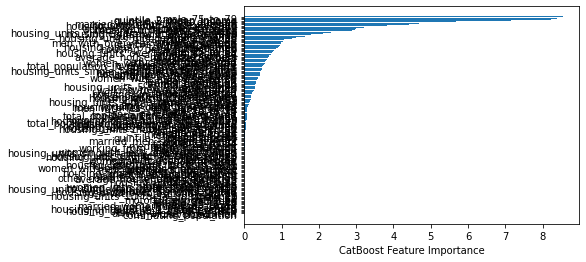

In [59]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

### Catboost

In [ ]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)

In [ ]:
feat_names = X_test.columns.to_list()

In [ ]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")